In [1]:
import numpy as np
import fenics as fe
fe.set_log_level(40)

from tqdm.notebook import tqdm_notebook

In [2]:
## Define heat conductivity $\lambda (\alpha)$ [W/(m K)]
def lambda_concrete(vf_aggr, vf_paste, alpha):
    """
    heat conductivity of concrete via multiscale homogenization [W/(m K)]
    """
    lambda_aggr= 3.0 # https://doi.org/10.1016/j.jrmge.2021.08.008 from graph for sand at zero porosity
    lambda_paste= 1.0

    lambda_ini_concrete_lower= lambda_paste + vf_aggr / (1/(lambda_aggr-lambda_paste) + vf_paste/(3*lambda_paste))
    lambda_ini_concrete_upper= lambda_aggr + vf_paste / (1/(lambda_paste-lambda_aggr) + vf_aggr/(3*lambda_aggr))
    lambda_ini_concrete_mean= (lambda_ini_concrete_lower+lambda_ini_concrete_upper)/2.

    lambda_concrete_sealed= lambda_ini_concrete_mean*(1+0.22*alpha)
    return lambda_concrete_sealed


## Define specific heat capacity $c(\alpha)$ [J/(kg K)]
def c_concrete(wcr, mf_aggr, mf_paste, alpha):
    """
    Specific heat capacity of concrete via multiscale homogenization [J/(kg K)]
    """
    c_water= 4180 # [J/(kg K)]
    c_cement= 750
    c_aggr= 800 # 10.13140/RG.2.1.1045.0403

    c_paste= (c_water*wcr+c_cement)/(1+wcr)*(1-0.26*(1-fe.exp(-2.9*alpha))) # assuming sealed conditions
    c_concrete= mf_aggr*c_aggr + mf_paste*c_paste
    return c_concrete


## Define affinity-based hydration model [1/s]
def evalChemAffinity(alpha):
    """
    Evaluate chemical affinity-based hydration model.
    Model parameters must be calibrated using isothermal calorimetry for each cement paste individually prior usage.
    """
    ## Calibration parameters of affinity-based hydration model for CEM I Ladce, 391 m^2/kg, wcr=0.5
    B1= 0.000141525
    B2= 0.00408201
    eta= 6.10436
    alpha_infty=0.85

    if alpha==0:
        Atld_ref=0
    else:
        Atld_ref= B1*(B2/alpha_infty+alpha)*(alpha_infty-alpha)*fe.exp(-eta*alpha/alpha_infty)

    return Atld_ref


## Define scaling parameter $\beta_T$ for temperature [$-$]
def betaT(T):
    """
    Evaluate scaling parameter from temperature fluctuation
    """
    Ea= 38300 # [J/mol], apparent activation energy
    R= 8.31441 # [J/(mol*K)], universal gas constant
    Tref= 293.15 # [K] = 20 C, reference temperature for which Atld_ref is measured

    betaT= fe.exp(Ea/R*(1/Tref-1/(T+273.15)))

    return betaT


## Define scaling parameter $\beta_H$ for humidity [$-$]
def betaH(H):
    """
    Evaluate scaling parameter from humidity fluctuation
    """
    a= 7.5 # [-] from [Bazant1972]
    betaH= 1./(1.+(a-a*H)**4.)
    return betaH



## Alternate diffusion coefficient $D_H$ [m^2/s] from [Bazant:1972]
def diffusivityBazant(H):
    """
    evaluates the diffusivity from [Bazant:1972]

    Parameters
    ----------
    H : float
        relative humidity [-].

    Returns
    -------
    DH
    """
#     # fib MC 2010 recomendation (also in [Oliveira:2015]):
#     fcm= 55 # [MPa]; estimated compressive strength of concrete
#     DH1= (1e-8)/(fcm-8) # = 4.5454e-10 m^2/s for fc=30; =39.3 mm^2/day
#     gamma= 0.05; Hc= 0.8; n= 15

#     #[Havlasek:2016]:
#     DH1= 2.8935e-10 # [m^2/s]; =25 mm^2/day => 25/8.64e+10 
#     gamma= 0.1; Hc= 0.8; n= 10 

    ##[Sovjak:2018]:
    #DH1= 4.6296e-10 # [m^2/s]; =40 mm^2/day => 40/8.64e+10
    #gamma= 0.05; Hc=0.75; n= 12
    
    ## my custom:
    DH1= 200/8.64e+10 # [m^2/s]
    gamma= 0.05 # 0.05 
    Hc=0.75 # 0.75 
    n= 12 # 12

    return DH1 * (gamma + (1-gamma)/(1+( (1-H)/(1-Hc) )**n))


## Hygrothermic coefficient [1/K] from [Bazant:1972]
def heat_rate(T_new, T_old, dt):
    return (T_new-T_old)/dt

def HTcoef(H_new):
    return 0.0135*H_new*(1-H_new)/(1.25-H_new)

In [3]:
width= 0.8 # 0.8, 0.4, 0.2
height= 0.8
thick= 0.8 # [m]; out-of-plane dimension, default= 1 m for extruded structures


## Mix design - mass of constituent to create a 1 m^3 of concrete
m_cement= 410 # [kg/m^3]
m_water= 180 # [kg/m^3]
m_fineAggr= 1460 # [kg/m^3]
m_coarseAggr= 300 # [kg/m^3]

rho_cement= 3140 # [kg/m^3] (estimated)
rho_water= 1000 # [kg/m^3] (estimated)
rho_aggr= 2600 # [kg/m^3] (estimated)


Hini= 0.955 # [-]; initial RH throughout the cross-section
humFlowSides= 1e-7 #5/8.64e7
humFlowBtm= 1.1574e-9 #5/8.64e7 # [m/s] coefficient of hygric exchange between surface and environment

H_remote= fe.Expression('newh', newh=0.396, degree=2)
variableHumidity= 1

if variableHumidity:
    humidity_file_path = 'DataExperiment_Vinkler2016_humidity.txt'
    def loadHumidityFromFile(humidity_file_path, given_time):
        data = np.loadtxt(humidity_file_path)
        time = data[:, 0]*24*60*60
        humidity = data[:, 1]/100
        interpolated_humidity = np.interp(given_time, time, humidity)
        return interpolated_humidity

# H_limit= 0.953 # limiting H for cold joint formation

## Time evaluation
total_time= 800*24*60*60 # [s]; target time
# dt= 5*60*60
dt= 1*60*60

In [4]:
## Mesh discretization
numElemW= 200#70
numElemH= numElemW * height/width

mesh = fe.RectangleMesh(fe.Point(0, 0), fe.Point(width, height), nx=int(numElemW), ny=int(numElemH), diagonal="right")

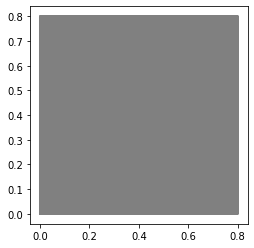

In [5]:
fe.plot(mesh)

In [6]:
quadrature_rules={'quadrature_degree' : 1, 'quadrature_scheme' : 'default'}

In [7]:
element_family = 'CG'

element = fe.FiniteElement(element_family, mesh.ufl_cell(),
                               degree=quadrature_rules.get('quadrature_degree'),
                               quad_scheme=quadrature_rules.get('quadrature_scheme'))
mixed_element = fe.MixedElement([element,])

W = fe.FunctionSpace(mesh, mixed_element)

u_ = fe.TestFunctions(W)

δu = fe.TrialFunction(W)

u_new = fe.Function(W)

u_old = fe.Function(W)

dx = fe.dx(metadata={'quadrature_degree': quadrature_rules['quadrature_degree']})

In [8]:
## Calculate mix proportions
rho_concrete= m_cement+m_water+m_fineAggr+m_coarseAggr # density of 1 m^3 of concrete

# Mix-related proportions of constituents: mf_* mass fraction; vf_* volume fraction
wcr= m_water/m_cement # water-to-cement mass ratio
mf_paste= (m_cement+m_water)/(m_cement+m_water+m_fineAggr+m_coarseAggr)
mf_aggr= (m_fineAggr+m_coarseAggr)/(m_cement+m_water+m_fineAggr+m_coarseAggr)

vf_paste= (m_cement/rho_cement+m_water/rho_water)/(m_cement/rho_cement+m_water/rho_water+m_fineAggr/rho_aggr+m_coarseAggr/rho_aggr)
vf_aggr= (m_fineAggr/rho_aggr+m_coarseAggr/rho_aggr)/(m_cement/rho_cement+m_water/rho_water+m_fineAggr/rho_aggr+m_coarseAggr/rho_aggr)


# Calculate dimension of the mesh
dim= mesh.topology().dim()

# Define boundary on mesh
surface_dim= dim - 1
boundaries= fe.MeshFunction("size_t", mesh, surface_dim)

# setting tags for all boundaries as 99
boundaries.set_all(99)

## Define INITIAL CONDITION
element_space = fe.FunctionSpace(mesh, element)

s = fe.Function(element_space)

s.interpolate(fe.Constant(Hini)) # discretize the IC onto the function space - translate to the nodal values on function space on this mesh
fe.assign(u_old, s)

## Boundary conditions
"""
mark BC ID as follows:

#3#
0 1
#2#

""" 
#### MARK BOUNDARIES:
left= fe.CompiledSubDomain("near(x[0], 0) && on_boundary")
left.mark(boundaries, 0)
# bc_left= fe.DirichletBC(W, fe.Constant((20.0)), left)

# right= fe.CompiledSubDomain("near(x[0], 0.10) && on_boundary")
right= fe.CompiledSubDomain("near(x[0], %.3f) && on_boundary" %(width))
right.mark(boundaries, 1)

bottom = fe.CompiledSubDomain("near(0, x[1]) && on_boundary")
bottom.mark(boundaries, 2)

# top= fe.CompiledSubDomain("near(0.50, x[1]) && on_boundary")
top= fe.CompiledSubDomain("near(%.3f, x[1]) && on_boundary" %(height))
top.mark(boundaries, 3)




bcs = []
#### ASSIGN BC FOR HUMIDITY :
hW= [humFlowSides, humFlowSides, humFlowBtm, humFlowSides] 
boundary_conditions_H = {0: {'Robin':     (hW[0], H_remote)}, #0: {'Dirichlet': fe.Constant(0.98)}
                     1: {'Robin':     (hW[1], H_remote)},
                     2: {'Robin':     (hW[2], H_remote)},
                     3: {'Robin':     (hW[3], H_remote)} }

#### Collect DIRICHLET BC:

for i in boundary_conditions_H:
    if 'Dirichlet' in boundary_conditions_H[i]:
        bcH= fe.DirichletBC(W, boundary_conditions_H[i]['Dirichlet'], boundaries, i)
        bcs.append(bcH)

ds = fe.Measure('ds', domain=mesh, subdomain_data=boundaries)  

#### Collect ROBIN BC:
integrals_R_a_H = []
integrals_R_L_H = []
for i in boundary_conditions_H:
    if 'Robin' in boundary_conditions_H[i]:
        r1, s1 = boundary_conditions_H[i]['Robin']
        integrals_R_a_H.append(r1*u_new[0]*u_[0]*ds(i))
        integrals_R_L_H.append(r1*s1*u_[0]*ds(i))


## Solution parameters
num_steps= int((total_time / dt) + 1) # number of time steps +1 at end to reach exact time

snes_solver_parameters = {"nonlinear_solver": "newton",
                      "newton_solver": {"linear_solver": "gmres",
                                        "preconditioner" :'ilu',
                                        "maximum_iterations": 100000,
                                        "report": False,
                                        "absolute_tolerance":1e-8,
                                        "relative_tolerance":1e-8,
                                        "error_on_nonconvergence": True}}


## Solve coupled problem
## Starting values
t= fe.Constant(0) # [sec] keep track of elapsed time, should be equal throughout cross-section

alpha= fe.Constant(0) # [-]
dalpha= 1e-7 # constant increment of alpha for numerical integration of time

# Qtot= Qpotential*m_cement*width*height*thick # total stored heat in assumed sample volume (cross-section * thickness) [J]


# def Qdot(alpha, T, H):
#     return Qtot * evalChemAffinity(alpha) * betaT(T) * betaH(H)

# def dwhdt(alpha, T, H):
#     return 0.23*m_cement*width*height*thick*evalChemAffinity(alpha) * betaT(T) * betaH(H) # evaluate water consumed by hydration

def DH(H):
    return diffusivityBazant(H)

# weak form for humidity
var = u_new[0]*u_[0]*dx \
    + dt*DH(u_new[0])*fe.dot(fe.grad(u_new[0]), fe.grad(u_[0]))*dx \
    + dt*sum(integrals_R_a_H) \
    - u_old[0]*u_[0]*dx \
    - dt*sum(integrals_R_L_H)


# solve variational problem
problem = fe.NonlinearVariationalProblem(var, u_new, bcs, fe.derivative(var, u_new, δu))

solver= fe.NonlinearVariationalSolver(problem)
solver.parameters.update(snes_solver_parameters)

In [9]:
save_dataTXT= 1
if save_dataTXT:
    expTXTfile= "MMdata_v8_validation_Vinkler2016_humidity_wall800_variableH.txt"
    fout= open(expTXTfile, 'w')

In [10]:
## SOLVE PROBLEM
for s in tqdm_notebook(range(0, num_steps)):

    if variableHumidity:
        H_remote.newh= loadHumidityFromFile(humidity_file_path, given_time= s*dt)
    
    solver.solve()
    u_old.assign(u_new)
        
    result = (
        s * dt / 24 / 60 / 60,
        u_old(width / 2., height / 2.), 
        u_old(0.05, height / 2.),
        u_old(0.015, height / 2.)
    )

    print(f"{result[0]:.3f}, {result[1]:.4f}, {result[2]:.4f}, {result[3]:.4f}")


    if save_dataTXT:
        fout.write('%.3f\t%.4f\t%.4f\t%.4f\t%.4f\t%.4f\n' 
                   %(s*dt/24/60./60.,
                     u_old(width / 2., height / 2.), 
                     u_old(0.1, height / 2.),
                     u_old(0.035, height / 2.),
                     u_old(0.03, height / 2.),
                     u_old(0.015, height / 2.)  
                    ) 
                  )

0.000, 0.9550, 0.9550, 0.9548
0.042, 0.9550, 0.9550, 0.9539
0.083, 0.9550, 0.9550, 0.9518
0.125, 0.9550, 0.9550, 0.9487
0.167, 0.9550, 0.9550, 0.9446
0.208, 0.9550, 0.9550, 0.9400
0.250, 0.9550, 0.9550, 0.9349
0.292, 0.9550, 0.9550, 0.9297
0.333, 0.9550, 0.9550, 0.9244
0.375, 0.9550, 0.9550, 0.9191
0.417, 0.9550, 0.9550, 0.9140
0.458, 0.9550, 0.9549, 0.9091
0.500, 0.9550, 0.9549, 0.9044
0.542, 0.9550, 0.9548, 0.9001
0.583, 0.9550, 0.9548, 0.8962
0.625, 0.9550, 0.9547, 0.8925
0.667, 0.9550, 0.9546, 0.8893
0.708, 0.9550, 0.9544, 0.8864
0.750, 0.9550, 0.9543, 0.8838
0.792, 0.9550, 0.9541, 0.8814
0.833, 0.9550, 0.9538, 0.8793
0.875, 0.9550, 0.9536, 0.8774
0.917, 0.9550, 0.9533, 0.8757
0.958, 0.9550, 0.9530, 0.8740
1.000, 0.9550, 0.9527, 0.8725
1.042, 0.9550, 0.9524, 0.8711
1.083, 0.9550, 0.9520, 0.8697
1.125, 0.9550, 0.9516, 0.8684
1.167, 0.9550, 0.9512, 0.8672
1.208, 0.9550, 0.9508, 0.8659
1.250, 0.9550, 0.9504, 0.8647
1.292, 0.9550, 0.9499, 0.8636
1.333, 0.9550, 0.9495, 0.8624
1.375, 0.9

11.375, 0.9550, 0.8575, 0.7686
11.417, 0.9550, 0.8573, 0.7685
11.458, 0.9550, 0.8571, 0.7684
11.500, 0.9550, 0.8569, 0.7683
11.542, 0.9550, 0.8567, 0.7681
11.583, 0.9550, 0.8565, 0.7680
11.625, 0.9550, 0.8563, 0.7679
11.667, 0.9550, 0.8561, 0.7678
11.708, 0.9550, 0.8559, 0.7676
11.750, 0.9550, 0.8557, 0.7675
11.792, 0.9550, 0.8555, 0.7674
11.833, 0.9550, 0.8554, 0.7672
11.875, 0.9550, 0.8552, 0.7671
11.917, 0.9550, 0.8550, 0.7670
11.958, 0.9550, 0.8548, 0.7669
12.000, 0.9550, 0.8546, 0.7667
12.042, 0.9550, 0.8544, 0.7666
12.083, 0.9550, 0.8542, 0.7665
12.125, 0.9550, 0.8540, 0.7663
12.167, 0.9550, 0.8538, 0.7662
12.208, 0.9550, 0.8537, 0.7661
12.250, 0.9550, 0.8535, 0.7660
12.292, 0.9550, 0.8533, 0.7658
12.333, 0.9550, 0.8531, 0.7657
12.375, 0.9550, 0.8529, 0.7656
12.417, 0.9550, 0.8527, 0.7655
12.458, 0.9550, 0.8526, 0.7653
12.500, 0.9550, 0.8524, 0.7652
12.542, 0.9550, 0.8522, 0.7651
12.583, 0.9550, 0.8520, 0.7650
12.625, 0.9550, 0.8518, 0.7648
12.667, 0.9550, 0.8517, 0.7647
12.708, 

22.417, 0.9550, 0.8227, 0.7402
22.458, 0.9550, 0.8226, 0.7401
22.500, 0.9550, 0.8225, 0.7400
22.542, 0.9550, 0.8225, 0.7399
22.583, 0.9550, 0.8224, 0.7398
22.625, 0.9550, 0.8223, 0.7397
22.667, 0.9550, 0.8222, 0.7396
22.708, 0.9550, 0.8221, 0.7395
22.750, 0.9550, 0.8220, 0.7394
22.792, 0.9550, 0.8219, 0.7393
22.833, 0.9550, 0.8219, 0.7393
22.875, 0.9550, 0.8218, 0.7392
22.917, 0.9550, 0.8217, 0.7391
22.958, 0.9550, 0.8216, 0.7390
23.000, 0.9550, 0.8215, 0.7389
23.042, 0.9550, 0.8214, 0.7388
23.083, 0.9550, 0.8213, 0.7387
23.125, 0.9550, 0.8213, 0.7386
23.167, 0.9550, 0.8212, 0.7385
23.208, 0.9550, 0.8211, 0.7384
23.250, 0.9550, 0.8210, 0.7383
23.292, 0.9550, 0.8209, 0.7382
23.333, 0.9550, 0.8208, 0.7381
23.375, 0.9550, 0.8207, 0.7380
23.417, 0.9550, 0.8207, 0.7380
23.458, 0.9550, 0.8206, 0.7379
23.500, 0.9550, 0.8205, 0.7378
23.542, 0.9550, 0.8204, 0.7377
23.583, 0.9550, 0.8203, 0.7376
23.625, 0.9550, 0.8202, 0.7375
23.667, 0.9550, 0.8202, 0.7374
23.708, 0.9550, 0.8201, 0.7373
23.750, 

33.500, 0.9547, 0.8049, 0.7181
33.542, 0.9547, 0.8048, 0.7180
33.583, 0.9547, 0.8048, 0.7180
33.625, 0.9547, 0.8047, 0.7179
33.667, 0.9547, 0.8047, 0.7178
33.708, 0.9546, 0.8046, 0.7177
33.750, 0.9546, 0.8046, 0.7177
33.792, 0.9546, 0.8045, 0.7176
33.833, 0.9546, 0.8045, 0.7175
33.875, 0.9546, 0.8044, 0.7174
33.917, 0.9546, 0.8044, 0.7174
33.958, 0.9546, 0.8043, 0.7173
34.000, 0.9546, 0.8043, 0.7172
34.042, 0.9546, 0.8042, 0.7172
34.083, 0.9546, 0.8042, 0.7171
34.125, 0.9546, 0.8041, 0.7170
34.167, 0.9546, 0.8041, 0.7169
34.208, 0.9546, 0.8040, 0.7169
34.250, 0.9546, 0.8040, 0.7168
34.292, 0.9546, 0.8039, 0.7167
34.333, 0.9546, 0.8039, 0.7167
34.375, 0.9546, 0.8038, 0.7166
34.417, 0.9546, 0.8038, 0.7165
34.458, 0.9546, 0.8037, 0.7164
34.500, 0.9546, 0.8037, 0.7164
34.542, 0.9546, 0.8036, 0.7163
34.583, 0.9546, 0.8036, 0.7162
34.625, 0.9546, 0.8035, 0.7162
34.667, 0.9546, 0.8035, 0.7161
34.708, 0.9546, 0.8034, 0.7160
34.750, 0.9546, 0.8034, 0.7159
34.792, 0.9546, 0.8033, 0.7159
34.833, 

44.542, 0.9533, 0.7937, 0.6965
44.583, 0.9533, 0.7937, 0.6964
44.625, 0.9532, 0.7937, 0.6963
44.667, 0.9532, 0.7936, 0.6962
44.708, 0.9532, 0.7936, 0.6961
44.750, 0.9532, 0.7936, 0.6960
44.792, 0.9532, 0.7935, 0.6959
44.833, 0.9532, 0.7935, 0.6958
44.875, 0.9532, 0.7935, 0.6956
44.917, 0.9532, 0.7934, 0.6955
44.958, 0.9532, 0.7934, 0.6954
45.000, 0.9532, 0.7933, 0.6953
45.042, 0.9532, 0.7933, 0.6952
45.083, 0.9532, 0.7933, 0.6950
45.125, 0.9531, 0.7932, 0.6949
45.167, 0.9531, 0.7932, 0.6948
45.208, 0.9531, 0.7932, 0.6947
45.250, 0.9531, 0.7931, 0.6945
45.292, 0.9531, 0.7931, 0.6944
45.333, 0.9531, 0.7931, 0.6943
45.375, 0.9531, 0.7930, 0.6942
45.417, 0.9531, 0.7930, 0.6940
45.458, 0.9531, 0.7930, 0.6939
45.500, 0.9531, 0.7929, 0.6938
45.542, 0.9531, 0.7929, 0.6936
45.583, 0.9531, 0.7929, 0.6935
45.625, 0.9530, 0.7928, 0.6934
45.667, 0.9530, 0.7928, 0.6933
45.708, 0.9530, 0.7928, 0.6931
45.750, 0.9530, 0.7927, 0.6930
45.792, 0.9530, 0.7927, 0.6929
45.833, 0.9530, 0.7927, 0.6927
45.875, 

55.583, 0.9503, 0.7852, 0.6622
55.625, 0.9502, 0.7852, 0.6620
55.667, 0.9502, 0.7852, 0.6618
55.708, 0.9502, 0.7851, 0.6616
55.750, 0.9502, 0.7851, 0.6614
55.792, 0.9502, 0.7851, 0.6613
55.833, 0.9502, 0.7850, 0.6611
55.875, 0.9501, 0.7850, 0.6609
55.917, 0.9501, 0.7850, 0.6607
55.958, 0.9501, 0.7850, 0.6605
56.000, 0.9501, 0.7849, 0.6603
56.042, 0.9501, 0.7849, 0.6601
56.083, 0.9501, 0.7849, 0.6599
56.125, 0.9501, 0.7848, 0.6597
56.167, 0.9500, 0.7848, 0.6595
56.208, 0.9500, 0.7848, 0.6593
56.250, 0.9500, 0.7847, 0.6591
56.292, 0.9500, 0.7847, 0.6588
56.333, 0.9500, 0.7847, 0.6586
56.375, 0.9500, 0.7847, 0.6584
56.417, 0.9500, 0.7846, 0.6582
56.458, 0.9499, 0.7846, 0.6580
56.500, 0.9499, 0.7846, 0.6577
56.542, 0.9499, 0.7845, 0.6575
56.583, 0.9499, 0.7845, 0.6573
56.625, 0.9499, 0.7845, 0.6571
56.667, 0.9499, 0.7845, 0.6569
56.708, 0.9498, 0.7844, 0.6567
56.750, 0.9498, 0.7844, 0.6565
56.792, 0.9498, 0.7844, 0.6563
56.833, 0.9498, 0.7843, 0.6561
56.875, 0.9498, 0.7843, 0.6560
56.917, 

66.625, 0.9456, 0.7784, 0.6533
66.667, 0.9456, 0.7784, 0.6532
66.708, 0.9456, 0.7784, 0.6532
66.750, 0.9455, 0.7783, 0.6531
66.792, 0.9455, 0.7783, 0.6530
66.833, 0.9455, 0.7783, 0.6529
66.875, 0.9455, 0.7783, 0.6529
66.917, 0.9454, 0.7783, 0.6528
66.958, 0.9454, 0.7782, 0.6527
67.000, 0.9454, 0.7782, 0.6526
67.042, 0.9454, 0.7782, 0.6525
67.083, 0.9454, 0.7782, 0.6524
67.125, 0.9453, 0.7782, 0.6523
67.167, 0.9453, 0.7782, 0.6522
67.208, 0.9453, 0.7781, 0.6521
67.250, 0.9453, 0.7781, 0.6520
67.292, 0.9453, 0.7781, 0.6519
67.333, 0.9452, 0.7781, 0.6518
67.375, 0.9452, 0.7781, 0.6517
67.417, 0.9452, 0.7780, 0.6515
67.458, 0.9452, 0.7780, 0.6514
67.500, 0.9452, 0.7780, 0.6513
67.542, 0.9451, 0.7780, 0.6512
67.583, 0.9451, 0.7780, 0.6510
67.625, 0.9451, 0.7779, 0.6509
67.667, 0.9451, 0.7779, 0.6508
67.708, 0.9451, 0.7779, 0.6507
67.750, 0.9450, 0.7779, 0.6506
67.792, 0.9450, 0.7779, 0.6505
67.833, 0.9450, 0.7778, 0.6504
67.875, 0.9450, 0.7778, 0.6502
67.917, 0.9450, 0.7778, 0.6501
67.958, 

77.667, 0.9396, 0.7733, 0.6477
77.708, 0.9395, 0.7733, 0.6478
77.750, 0.9395, 0.7733, 0.6478
77.792, 0.9395, 0.7733, 0.6479
77.833, 0.9395, 0.7733, 0.6479
77.875, 0.9394, 0.7733, 0.6480
77.917, 0.9394, 0.7732, 0.6480
77.958, 0.9394, 0.7732, 0.6480
78.000, 0.9394, 0.7732, 0.6481
78.042, 0.9393, 0.7732, 0.6481
78.083, 0.9393, 0.7732, 0.6482
78.125, 0.9393, 0.7732, 0.6482
78.167, 0.9393, 0.7731, 0.6482
78.208, 0.9392, 0.7731, 0.6483
78.250, 0.9392, 0.7731, 0.6483
78.292, 0.9392, 0.7731, 0.6483
78.333, 0.9392, 0.7731, 0.6483
78.375, 0.9391, 0.7731, 0.6483
78.417, 0.9391, 0.7731, 0.6483
78.458, 0.9391, 0.7730, 0.6483
78.500, 0.9391, 0.7730, 0.6483
78.542, 0.9390, 0.7730, 0.6483
78.583, 0.9390, 0.7730, 0.6483
78.625, 0.9390, 0.7730, 0.6483
78.667, 0.9390, 0.7730, 0.6483
78.708, 0.9389, 0.7729, 0.6482
78.750, 0.9389, 0.7729, 0.6482
78.792, 0.9389, 0.7729, 0.6482
78.833, 0.9389, 0.7729, 0.6481
78.875, 0.9388, 0.7729, 0.6481
78.917, 0.9388, 0.7729, 0.6481
78.958, 0.9388, 0.7728, 0.6480
79.000, 

88.792, 0.9325, 0.7691, 0.6295
88.833, 0.9325, 0.7691, 0.6296
88.875, 0.9324, 0.7690, 0.6296
88.917, 0.9324, 0.7690, 0.6296
88.958, 0.9324, 0.7690, 0.6297
89.000, 0.9323, 0.7690, 0.6297
89.042, 0.9323, 0.7690, 0.6298
89.083, 0.9323, 0.7690, 0.6298
89.125, 0.9323, 0.7689, 0.6298
89.167, 0.9322, 0.7689, 0.6299
89.208, 0.9322, 0.7689, 0.6299
89.250, 0.9322, 0.7689, 0.6300
89.292, 0.9321, 0.7689, 0.6300
89.333, 0.9321, 0.7689, 0.6301
89.375, 0.9321, 0.7688, 0.6301
89.417, 0.9321, 0.7688, 0.6302
89.458, 0.9320, 0.7688, 0.6302
89.500, 0.9320, 0.7688, 0.6303
89.542, 0.9320, 0.7688, 0.6303
89.583, 0.9320, 0.7688, 0.6304
89.625, 0.9319, 0.7687, 0.6305
89.667, 0.9319, 0.7687, 0.6305
89.708, 0.9319, 0.7687, 0.6306
89.750, 0.9318, 0.7687, 0.6306
89.792, 0.9318, 0.7687, 0.6307
89.833, 0.9318, 0.7687, 0.6307
89.875, 0.9318, 0.7686, 0.6308
89.917, 0.9317, 0.7686, 0.6308
89.958, 0.9317, 0.7686, 0.6309
90.000, 0.9317, 0.7686, 0.6309
90.042, 0.9316, 0.7686, 0.6310
90.083, 0.9316, 0.7686, 0.6310
90.125, 

99.875, 0.9248, 0.7651, 0.6177
99.917, 0.9247, 0.7651, 0.6176
99.958, 0.9247, 0.7651, 0.6175
100.000, 0.9247, 0.7651, 0.6173
100.042, 0.9247, 0.7651, 0.6172
100.083, 0.9246, 0.7651, 0.6171
100.125, 0.9246, 0.7651, 0.6170
100.167, 0.9246, 0.7650, 0.6168
100.208, 0.9245, 0.7650, 0.6167
100.250, 0.9245, 0.7650, 0.6166
100.292, 0.9245, 0.7650, 0.6165
100.333, 0.9244, 0.7650, 0.6163
100.375, 0.9244, 0.7650, 0.6162
100.417, 0.9244, 0.7650, 0.6161
100.458, 0.9244, 0.7649, 0.6160
100.500, 0.9243, 0.7649, 0.6159
100.542, 0.9243, 0.7649, 0.6158
100.583, 0.9243, 0.7649, 0.6157
100.625, 0.9242, 0.7649, 0.6156
100.667, 0.9242, 0.7649, 0.6155
100.708, 0.9242, 0.7649, 0.6154
100.750, 0.9241, 0.7648, 0.6153
100.792, 0.9241, 0.7648, 0.6152
100.833, 0.9241, 0.7648, 0.6151
100.875, 0.9241, 0.7648, 0.6151
100.917, 0.9240, 0.7648, 0.6150
100.958, 0.9240, 0.7648, 0.6149
101.000, 0.9240, 0.7648, 0.6149
101.042, 0.9239, 0.7647, 0.6148
101.083, 0.9239, 0.7647, 0.6148
101.125, 0.9239, 0.7647, 0.6147
101.167, 0.

110.583, 0.9170, 0.7617, 0.6269
110.625, 0.9169, 0.7617, 0.6270
110.667, 0.9169, 0.7617, 0.6272
110.708, 0.9169, 0.7617, 0.6273
110.750, 0.9168, 0.7617, 0.6274
110.792, 0.9168, 0.7617, 0.6276
110.833, 0.9168, 0.7616, 0.6277
110.875, 0.9168, 0.7616, 0.6278
110.917, 0.9167, 0.7616, 0.6280
110.958, 0.9167, 0.7616, 0.6281
111.000, 0.9167, 0.7616, 0.6283
111.042, 0.9166, 0.7616, 0.6284
111.083, 0.9166, 0.7616, 0.6286
111.125, 0.9166, 0.7616, 0.6288
111.167, 0.9165, 0.7616, 0.6289
111.208, 0.9165, 0.7615, 0.6291
111.250, 0.9165, 0.7615, 0.6292
111.292, 0.9164, 0.7615, 0.6294
111.333, 0.9164, 0.7615, 0.6296
111.375, 0.9164, 0.7615, 0.6297
111.417, 0.9164, 0.7615, 0.6299
111.458, 0.9163, 0.7615, 0.6301
111.500, 0.9163, 0.7615, 0.6303
111.542, 0.9163, 0.7615, 0.6305
111.583, 0.9162, 0.7614, 0.6307
111.625, 0.9162, 0.7614, 0.6309
111.667, 0.9162, 0.7614, 0.6311
111.708, 0.9161, 0.7614, 0.6313
111.750, 0.9161, 0.7614, 0.6315
111.792, 0.9161, 0.7614, 0.6318
111.833, 0.9160, 0.7614, 0.6320
111.875,

121.333, 0.9090, 0.7598, 0.6458
121.375, 0.9090, 0.7598, 0.6457
121.417, 0.9089, 0.7597, 0.6456
121.458, 0.9089, 0.7597, 0.6456
121.500, 0.9089, 0.7597, 0.6455
121.542, 0.9089, 0.7597, 0.6454
121.583, 0.9088, 0.7597, 0.6454
121.625, 0.9088, 0.7597, 0.6453
121.667, 0.9088, 0.7597, 0.6452
121.708, 0.9087, 0.7597, 0.6452
121.750, 0.9087, 0.7597, 0.6451
121.792, 0.9087, 0.7597, 0.6450
121.833, 0.9086, 0.7597, 0.6450
121.875, 0.9086, 0.7597, 0.6449
121.917, 0.9086, 0.7597, 0.6448
121.958, 0.9085, 0.7597, 0.6448
122.000, 0.9085, 0.7596, 0.6447
122.042, 0.9085, 0.7596, 0.6446
122.083, 0.9084, 0.7596, 0.6446
122.125, 0.9084, 0.7596, 0.6445
122.167, 0.9084, 0.7596, 0.6444
122.208, 0.9084, 0.7596, 0.6444
122.250, 0.9083, 0.7596, 0.6443
122.292, 0.9083, 0.7596, 0.6442
122.333, 0.9083, 0.7596, 0.6442
122.375, 0.9082, 0.7596, 0.6441
122.417, 0.9082, 0.7596, 0.6440
122.458, 0.9082, 0.7596, 0.6439
122.500, 0.9081, 0.7596, 0.6439
122.542, 0.9081, 0.7595, 0.6438
122.583, 0.9081, 0.7595, 0.6437
122.625,

132.042, 0.9011, 0.7572, 0.6390
132.083, 0.9011, 0.7572, 0.6390
132.125, 0.9010, 0.7572, 0.6391
132.167, 0.9010, 0.7572, 0.6391
132.208, 0.9010, 0.7572, 0.6391
132.250, 0.9009, 0.7572, 0.6391
132.292, 0.9009, 0.7571, 0.6392
132.333, 0.9009, 0.7571, 0.6392
132.375, 0.9008, 0.7571, 0.6392
132.417, 0.9008, 0.7571, 0.6393
132.458, 0.9008, 0.7571, 0.6393
132.500, 0.9008, 0.7571, 0.6393
132.542, 0.9007, 0.7571, 0.6393
132.583, 0.9007, 0.7571, 0.6394
132.625, 0.9007, 0.7571, 0.6394
132.667, 0.9006, 0.7571, 0.6395
132.708, 0.9006, 0.7570, 0.6395
132.750, 0.9006, 0.7570, 0.6396
132.792, 0.9005, 0.7570, 0.6396
132.833, 0.9005, 0.7570, 0.6397
132.875, 0.9005, 0.7570, 0.6397
132.917, 0.9005, 0.7570, 0.6398
132.958, 0.9004, 0.7570, 0.6399
133.000, 0.9004, 0.7570, 0.6400
133.042, 0.9004, 0.7570, 0.6400
133.083, 0.9003, 0.7570, 0.6401
133.125, 0.9003, 0.7569, 0.6402
133.167, 0.9003, 0.7569, 0.6403
133.208, 0.9002, 0.7569, 0.6404
133.250, 0.9002, 0.7569, 0.6405
133.292, 0.9002, 0.7569, 0.6405
133.333,

142.750, 0.8933, 0.7550, 0.6499
142.792, 0.8933, 0.7550, 0.6499
142.833, 0.8933, 0.7550, 0.6499
142.875, 0.8932, 0.7549, 0.6499
142.917, 0.8932, 0.7549, 0.6499
142.958, 0.8932, 0.7549, 0.6498
143.000, 0.8931, 0.7549, 0.6498
143.042, 0.8931, 0.7549, 0.6498
143.083, 0.8931, 0.7549, 0.6497
143.125, 0.8930, 0.7549, 0.6497
143.167, 0.8930, 0.7549, 0.6496
143.208, 0.8930, 0.7549, 0.6496
143.250, 0.8930, 0.7549, 0.6495
143.292, 0.8929, 0.7549, 0.6495
143.333, 0.8929, 0.7549, 0.6494
143.375, 0.8929, 0.7549, 0.6494
143.417, 0.8928, 0.7548, 0.6493
143.458, 0.8928, 0.7548, 0.6492
143.500, 0.8928, 0.7548, 0.6492
143.542, 0.8927, 0.7548, 0.6491
143.583, 0.8927, 0.7548, 0.6490
143.625, 0.8927, 0.7548, 0.6490
143.667, 0.8927, 0.7548, 0.6489
143.708, 0.8926, 0.7548, 0.6488
143.750, 0.8926, 0.7548, 0.6488
143.792, 0.8926, 0.7548, 0.6487
143.833, 0.8925, 0.7548, 0.6486
143.875, 0.8925, 0.7548, 0.6485
143.917, 0.8925, 0.7548, 0.6485
143.958, 0.8924, 0.7548, 0.6484
144.000, 0.8924, 0.7547, 0.6483
144.042,

153.458, 0.8857, 0.7531, 0.6626
153.500, 0.8857, 0.7531, 0.6627
153.542, 0.8857, 0.7531, 0.6627
153.583, 0.8857, 0.7531, 0.6627
153.625, 0.8856, 0.7531, 0.6628
153.667, 0.8856, 0.7531, 0.6628
153.708, 0.8856, 0.7531, 0.6628
153.750, 0.8855, 0.7531, 0.6628
153.792, 0.8855, 0.7531, 0.6628
153.833, 0.8855, 0.7531, 0.6628
153.875, 0.8855, 0.7530, 0.6628
153.917, 0.8854, 0.7530, 0.6628
153.958, 0.8854, 0.7530, 0.6628
154.000, 0.8854, 0.7530, 0.6628
154.042, 0.8853, 0.7530, 0.6628
154.083, 0.8853, 0.7530, 0.6628
154.125, 0.8853, 0.7530, 0.6628
154.167, 0.8853, 0.7530, 0.6628
154.208, 0.8852, 0.7530, 0.6627
154.250, 0.8852, 0.7530, 0.6627
154.292, 0.8852, 0.7530, 0.6627
154.333, 0.8851, 0.7530, 0.6626
154.375, 0.8851, 0.7530, 0.6626
154.417, 0.8851, 0.7530, 0.6625
154.458, 0.8851, 0.7530, 0.6625
154.500, 0.8850, 0.7530, 0.6624
154.542, 0.8850, 0.7530, 0.6624
154.583, 0.8850, 0.7530, 0.6623
154.625, 0.8849, 0.7530, 0.6623
154.667, 0.8849, 0.7530, 0.6622
154.708, 0.8849, 0.7530, 0.6622
154.750,

164.167, 0.8784, 0.7514, 0.6511
164.208, 0.8784, 0.7514, 0.6510
164.250, 0.8784, 0.7514, 0.6510
164.292, 0.8784, 0.7514, 0.6510
164.333, 0.8783, 0.7514, 0.6509
164.375, 0.8783, 0.7514, 0.6509
164.417, 0.8783, 0.7514, 0.6509
164.458, 0.8783, 0.7514, 0.6508
164.500, 0.8782, 0.7514, 0.6508
164.542, 0.8782, 0.7514, 0.6508
164.583, 0.8782, 0.7514, 0.6508
164.625, 0.8781, 0.7513, 0.6507
164.667, 0.8781, 0.7513, 0.6507
164.708, 0.8781, 0.7513, 0.6507
164.750, 0.8781, 0.7513, 0.6507
164.792, 0.8780, 0.7513, 0.6506
164.833, 0.8780, 0.7513, 0.6506
164.875, 0.8780, 0.7513, 0.6506
164.917, 0.8779, 0.7513, 0.6506
164.958, 0.8779, 0.7513, 0.6506
165.000, 0.8779, 0.7513, 0.6506
165.042, 0.8779, 0.7513, 0.6505
165.083, 0.8778, 0.7513, 0.6505
165.125, 0.8778, 0.7512, 0.6505
165.167, 0.8778, 0.7512, 0.6505
165.208, 0.8778, 0.7512, 0.6505
165.250, 0.8777, 0.7512, 0.6506
165.292, 0.8777, 0.7512, 0.6506
165.333, 0.8777, 0.7512, 0.6506
165.375, 0.8776, 0.7512, 0.6506
165.417, 0.8776, 0.7512, 0.6506
165.458,

174.917, 0.8714, 0.7494, 0.6534
174.958, 0.8714, 0.7494, 0.6534
175.000, 0.8714, 0.7494, 0.6534
175.042, 0.8713, 0.7494, 0.6534
175.083, 0.8713, 0.7494, 0.6534
175.125, 0.8713, 0.7494, 0.6534
175.167, 0.8713, 0.7493, 0.6534
175.208, 0.8712, 0.7493, 0.6534
175.250, 0.8712, 0.7493, 0.6533
175.292, 0.8712, 0.7493, 0.6533
175.333, 0.8712, 0.7493, 0.6533
175.375, 0.8711, 0.7493, 0.6533
175.417, 0.8711, 0.7493, 0.6533
175.458, 0.8711, 0.7493, 0.6533
175.500, 0.8711, 0.7493, 0.6532
175.542, 0.8710, 0.7493, 0.6532
175.583, 0.8710, 0.7493, 0.6532
175.625, 0.8710, 0.7493, 0.6532
175.667, 0.8709, 0.7493, 0.6532
175.708, 0.8709, 0.7492, 0.6531
175.750, 0.8709, 0.7492, 0.6531
175.792, 0.8709, 0.7492, 0.6531
175.833, 0.8708, 0.7492, 0.6530
175.875, 0.8708, 0.7492, 0.6530
175.917, 0.8708, 0.7492, 0.6530
175.958, 0.8708, 0.7492, 0.6529
176.000, 0.8707, 0.7492, 0.6529
176.042, 0.8707, 0.7492, 0.6529
176.083, 0.8707, 0.7492, 0.6528
176.125, 0.8707, 0.7492, 0.6528
176.167, 0.8706, 0.7492, 0.6527
176.208,

185.667, 0.8647, 0.7470, 0.6403
185.708, 0.8647, 0.7470, 0.6404
185.750, 0.8647, 0.7470, 0.6405
185.792, 0.8647, 0.7470, 0.6406
185.833, 0.8646, 0.7470, 0.6407
185.875, 0.8646, 0.7469, 0.6408
185.917, 0.8646, 0.7469, 0.6409
185.958, 0.8646, 0.7469, 0.6410
186.000, 0.8645, 0.7469, 0.6411
186.042, 0.8645, 0.7469, 0.6413
186.083, 0.8645, 0.7469, 0.6414
186.125, 0.8645, 0.7469, 0.6415
186.167, 0.8644, 0.7469, 0.6416
186.208, 0.8644, 0.7468, 0.6417
186.250, 0.8644, 0.7468, 0.6418
186.292, 0.8644, 0.7468, 0.6419
186.333, 0.8643, 0.7468, 0.6420
186.375, 0.8643, 0.7468, 0.6421
186.417, 0.8643, 0.7468, 0.6422
186.458, 0.8643, 0.7468, 0.6423
186.500, 0.8642, 0.7468, 0.6424
186.542, 0.8642, 0.7468, 0.6425
186.583, 0.8642, 0.7467, 0.6426
186.625, 0.8642, 0.7467, 0.6427
186.667, 0.8641, 0.7467, 0.6428
186.708, 0.8641, 0.7467, 0.6429
186.750, 0.8641, 0.7467, 0.6430
186.792, 0.8640, 0.7467, 0.6431
186.833, 0.8640, 0.7467, 0.6431
186.875, 0.8640, 0.7467, 0.6432
186.917, 0.8640, 0.7467, 0.6433
186.958,

196.375, 0.8584, 0.7448, 0.6309
196.417, 0.8584, 0.7448, 0.6306
196.458, 0.8583, 0.7448, 0.6304
196.500, 0.8583, 0.7448, 0.6302
196.542, 0.8583, 0.7448, 0.6300
196.583, 0.8583, 0.7448, 0.6298
196.625, 0.8582, 0.7447, 0.6295
196.667, 0.8582, 0.7447, 0.6293
196.708, 0.8582, 0.7447, 0.6291
196.750, 0.8582, 0.7447, 0.6289
196.792, 0.8582, 0.7447, 0.6287
196.833, 0.8581, 0.7447, 0.6285
196.875, 0.8581, 0.7447, 0.6282
196.917, 0.8581, 0.7447, 0.6280
196.958, 0.8581, 0.7447, 0.6278
197.000, 0.8580, 0.7447, 0.6276
197.042, 0.8580, 0.7447, 0.6274
197.083, 0.8580, 0.7447, 0.6272
197.125, 0.8580, 0.7446, 0.6270
197.167, 0.8579, 0.7446, 0.6268
197.208, 0.8579, 0.7446, 0.6266
197.250, 0.8579, 0.7446, 0.6264
197.292, 0.8579, 0.7446, 0.6263
197.333, 0.8578, 0.7446, 0.6261
197.375, 0.8578, 0.7446, 0.6259
197.417, 0.8578, 0.7446, 0.6257
197.458, 0.8578, 0.7446, 0.6256
197.500, 0.8577, 0.7446, 0.6254
197.542, 0.8577, 0.7446, 0.6252
197.583, 0.8577, 0.7445, 0.6251
197.625, 0.8577, 0.7445, 0.6249
197.667,

207.125, 0.8524, 0.7417, 0.6118
207.167, 0.8523, 0.7417, 0.6118
207.208, 0.8523, 0.7417, 0.6118
207.250, 0.8523, 0.7417, 0.6119
207.292, 0.8523, 0.7417, 0.6119
207.333, 0.8522, 0.7416, 0.6119
207.375, 0.8522, 0.7416, 0.6119
207.417, 0.8522, 0.7416, 0.6119
207.458, 0.8522, 0.7416, 0.6120
207.500, 0.8522, 0.7416, 0.6120
207.542, 0.8521, 0.7416, 0.6120
207.583, 0.8521, 0.7416, 0.6120
207.625, 0.8521, 0.7415, 0.6120
207.667, 0.8521, 0.7415, 0.6120
207.708, 0.8520, 0.7415, 0.6121
207.750, 0.8520, 0.7415, 0.6121
207.792, 0.8520, 0.7415, 0.6121
207.833, 0.8520, 0.7415, 0.6121
207.875, 0.8519, 0.7415, 0.6121
207.917, 0.8519, 0.7414, 0.6121
207.958, 0.8519, 0.7414, 0.6121
208.000, 0.8519, 0.7414, 0.6121
208.042, 0.8519, 0.7414, 0.6122
208.083, 0.8518, 0.7414, 0.6122
208.125, 0.8518, 0.7414, 0.6122
208.167, 0.8518, 0.7414, 0.6122
208.208, 0.8518, 0.7414, 0.6122
208.250, 0.8517, 0.7413, 0.6122
208.292, 0.8517, 0.7413, 0.6122
208.333, 0.8517, 0.7413, 0.6122
208.375, 0.8517, 0.7413, 0.6122
208.417,

217.833, 0.8467, 0.7386, 0.6062
217.875, 0.8466, 0.7386, 0.6063
217.917, 0.8466, 0.7386, 0.6064
217.958, 0.8466, 0.7386, 0.6066
218.000, 0.8466, 0.7386, 0.6067
218.042, 0.8466, 0.7386, 0.6069
218.083, 0.8465, 0.7386, 0.6070
218.125, 0.8465, 0.7386, 0.6072
218.167, 0.8465, 0.7386, 0.6074
218.208, 0.8465, 0.7385, 0.6075
218.250, 0.8464, 0.7385, 0.6077
218.292, 0.8464, 0.7385, 0.6079
218.333, 0.8464, 0.7385, 0.6081
218.375, 0.8464, 0.7385, 0.6082
218.417, 0.8464, 0.7385, 0.6084
218.458, 0.8463, 0.7385, 0.6086
218.500, 0.8463, 0.7385, 0.6088
218.542, 0.8463, 0.7385, 0.6090
218.583, 0.8463, 0.7384, 0.6092
218.625, 0.8463, 0.7384, 0.6093
218.667, 0.8462, 0.7384, 0.6095
218.708, 0.8462, 0.7384, 0.6097
218.750, 0.8462, 0.7384, 0.6099
218.792, 0.8462, 0.7384, 0.6101
218.833, 0.8461, 0.7384, 0.6103
218.875, 0.8461, 0.7384, 0.6105
218.917, 0.8461, 0.7383, 0.6107
218.958, 0.8461, 0.7383, 0.6109
219.000, 0.8461, 0.7383, 0.6110
219.042, 0.8460, 0.7383, 0.6112
219.083, 0.8460, 0.7383, 0.6114
219.125,

228.583, 0.8413, 0.7362, 0.6181
228.625, 0.8412, 0.7362, 0.6182
228.667, 0.8412, 0.7362, 0.6182
228.708, 0.8412, 0.7362, 0.6183
228.750, 0.8412, 0.7362, 0.6183
228.792, 0.8412, 0.7362, 0.6184
228.833, 0.8411, 0.7362, 0.6185
228.875, 0.8411, 0.7362, 0.6186
228.917, 0.8411, 0.7362, 0.6186
228.958, 0.8411, 0.7362, 0.6187
229.000, 0.8410, 0.7362, 0.6188
229.042, 0.8410, 0.7362, 0.6189
229.083, 0.8410, 0.7361, 0.6190
229.125, 0.8410, 0.7361, 0.6191
229.167, 0.8410, 0.7361, 0.6192
229.208, 0.8409, 0.7361, 0.6193
229.250, 0.8409, 0.7361, 0.6194
229.292, 0.8409, 0.7361, 0.6195
229.333, 0.8409, 0.7361, 0.6196
229.375, 0.8409, 0.7361, 0.6197
229.417, 0.8408, 0.7361, 0.6198
229.458, 0.8408, 0.7361, 0.6199
229.500, 0.8408, 0.7361, 0.6200
229.542, 0.8408, 0.7361, 0.6201
229.583, 0.8408, 0.7361, 0.6202
229.625, 0.8407, 0.7361, 0.6203
229.667, 0.8407, 0.7360, 0.6204
229.708, 0.8407, 0.7360, 0.6205
229.750, 0.8407, 0.7360, 0.6206
229.792, 0.8407, 0.7360, 0.6207
229.833, 0.8406, 0.7360, 0.6208
229.875,

239.333, 0.8361, 0.7345, 0.6113
239.375, 0.8361, 0.7345, 0.6112
239.417, 0.8361, 0.7345, 0.6112
239.458, 0.8361, 0.7345, 0.6112
239.500, 0.8361, 0.7345, 0.6112
239.542, 0.8360, 0.7344, 0.6111
239.583, 0.8360, 0.7344, 0.6111
239.625, 0.8360, 0.7344, 0.6111
239.667, 0.8360, 0.7344, 0.6111
239.708, 0.8360, 0.7344, 0.6111
239.750, 0.8359, 0.7344, 0.6111
239.792, 0.8359, 0.7344, 0.6111
239.833, 0.8359, 0.7344, 0.6111
239.875, 0.8359, 0.7344, 0.6111
239.917, 0.8359, 0.7344, 0.6111
239.958, 0.8358, 0.7344, 0.6111
240.000, 0.8358, 0.7344, 0.6111
240.042, 0.8358, 0.7344, 0.6111
240.083, 0.8358, 0.7344, 0.6111
240.125, 0.8358, 0.7343, 0.6111
240.167, 0.8357, 0.7343, 0.6111
240.208, 0.8357, 0.7343, 0.6111
240.250, 0.8357, 0.7343, 0.6111
240.292, 0.8357, 0.7343, 0.6111
240.333, 0.8357, 0.7343, 0.6112
240.375, 0.8357, 0.7343, 0.6112
240.417, 0.8356, 0.7343, 0.6112
240.458, 0.8356, 0.7343, 0.6112
240.500, 0.8356, 0.7343, 0.6112
240.542, 0.8356, 0.7343, 0.6113
240.583, 0.8356, 0.7343, 0.6113
240.625,

250.042, 0.8313, 0.7324, 0.6393
250.083, 0.8313, 0.7324, 0.6394
250.125, 0.8313, 0.7324, 0.6394
250.167, 0.8312, 0.7324, 0.6394
250.208, 0.8312, 0.7324, 0.6394
250.250, 0.8312, 0.7324, 0.6394
250.292, 0.8312, 0.7324, 0.6394
250.333, 0.8312, 0.7324, 0.6394
250.375, 0.8312, 0.7324, 0.6394
250.417, 0.8311, 0.7324, 0.6394
250.458, 0.8311, 0.7324, 0.6394
250.500, 0.8311, 0.7324, 0.6394
250.542, 0.8311, 0.7323, 0.6394
250.583, 0.8311, 0.7323, 0.6394
250.625, 0.8310, 0.7323, 0.6394
250.667, 0.8310, 0.7323, 0.6394
250.708, 0.8310, 0.7323, 0.6394
250.750, 0.8310, 0.7323, 0.6394
250.792, 0.8310, 0.7323, 0.6394
250.833, 0.8310, 0.7323, 0.6394
250.875, 0.8309, 0.7323, 0.6393
250.917, 0.8309, 0.7323, 0.6393
250.958, 0.8309, 0.7323, 0.6393
251.000, 0.8309, 0.7323, 0.6393
251.042, 0.8309, 0.7323, 0.6392
251.083, 0.8308, 0.7323, 0.6392
251.125, 0.8308, 0.7323, 0.6392
251.167, 0.8308, 0.7323, 0.6391
251.208, 0.8308, 0.7323, 0.6391
251.250, 0.8308, 0.7323, 0.6390
251.292, 0.8308, 0.7323, 0.6390
251.333,

260.792, 0.8267, 0.7314, 0.6271
260.833, 0.8267, 0.7314, 0.6270
260.875, 0.8267, 0.7314, 0.6269
260.917, 0.8267, 0.7314, 0.6267
260.958, 0.8266, 0.7314, 0.6266
261.000, 0.8266, 0.7314, 0.6265
261.042, 0.8266, 0.7314, 0.6263
261.083, 0.8266, 0.7314, 0.6262
261.125, 0.8266, 0.7314, 0.6260
261.167, 0.8265, 0.7314, 0.6259
261.208, 0.8265, 0.7314, 0.6258
261.250, 0.8265, 0.7314, 0.6256
261.292, 0.8265, 0.7314, 0.6255
261.333, 0.8265, 0.7314, 0.6254
261.375, 0.8265, 0.7314, 0.6252
261.417, 0.8264, 0.7314, 0.6251
261.458, 0.8264, 0.7313, 0.6249
261.500, 0.8264, 0.7313, 0.6248
261.542, 0.8264, 0.7313, 0.6247
261.583, 0.8264, 0.7313, 0.6245
261.625, 0.8264, 0.7313, 0.6244
261.667, 0.8263, 0.7313, 0.6243
261.708, 0.8263, 0.7313, 0.6241
261.750, 0.8263, 0.7313, 0.6240
261.792, 0.8263, 0.7313, 0.6239
261.833, 0.8263, 0.7313, 0.6238
261.875, 0.8263, 0.7313, 0.6236
261.917, 0.8262, 0.7313, 0.6235
261.958, 0.8262, 0.7313, 0.6234
262.000, 0.8262, 0.7313, 0.6233
262.042, 0.8262, 0.7313, 0.6232
262.083,

271.542, 0.8224, 0.7296, 0.6411
271.583, 0.8223, 0.7296, 0.6409
271.625, 0.8223, 0.7296, 0.6408
271.667, 0.8223, 0.7296, 0.6407
271.708, 0.8223, 0.7295, 0.6405
271.750, 0.8223, 0.7295, 0.6404
271.792, 0.8223, 0.7295, 0.6403
271.833, 0.8222, 0.7295, 0.6401
271.875, 0.8222, 0.7295, 0.6400
271.917, 0.8222, 0.7295, 0.6398
271.958, 0.8222, 0.7295, 0.6397
272.000, 0.8222, 0.7295, 0.6395
272.042, 0.8222, 0.7295, 0.6393
272.083, 0.8221, 0.7295, 0.6392
272.125, 0.8221, 0.7295, 0.6390
272.167, 0.8221, 0.7295, 0.6388
272.208, 0.8221, 0.7295, 0.6386
272.250, 0.8221, 0.7295, 0.6385
272.292, 0.8221, 0.7295, 0.6383
272.333, 0.8220, 0.7295, 0.6381
272.375, 0.8220, 0.7295, 0.6379
272.417, 0.8220, 0.7295, 0.6377
272.458, 0.8220, 0.7295, 0.6375
272.500, 0.8220, 0.7295, 0.6373
272.542, 0.8220, 0.7294, 0.6371
272.583, 0.8219, 0.7294, 0.6369
272.625, 0.8219, 0.7294, 0.6366
272.667, 0.8219, 0.7294, 0.6364
272.708, 0.8219, 0.7294, 0.6362
272.750, 0.8219, 0.7294, 0.6360
272.792, 0.8219, 0.7294, 0.6358
272.833,

282.250, 0.8182, 0.7278, 0.5879
282.292, 0.8182, 0.7278, 0.5878
282.333, 0.8182, 0.7278, 0.5877
282.375, 0.8182, 0.7278, 0.5875
282.417, 0.8182, 0.7278, 0.5874
282.458, 0.8182, 0.7278, 0.5873
282.500, 0.8182, 0.7278, 0.5872
282.542, 0.8181, 0.7277, 0.5870
282.583, 0.8181, 0.7277, 0.5869
282.625, 0.8181, 0.7277, 0.5868
282.667, 0.8181, 0.7277, 0.5867
282.708, 0.8181, 0.7277, 0.5866
282.750, 0.8181, 0.7277, 0.5864
282.792, 0.8180, 0.7277, 0.5863
282.833, 0.8180, 0.7277, 0.5862
282.875, 0.8180, 0.7276, 0.5861
282.917, 0.8180, 0.7276, 0.5860
282.958, 0.8180, 0.7276, 0.5859
283.000, 0.8180, 0.7276, 0.5858
283.042, 0.8180, 0.7276, 0.5857
283.083, 0.8179, 0.7276, 0.5856
283.125, 0.8179, 0.7276, 0.5855
283.167, 0.8179, 0.7276, 0.5854
283.208, 0.8179, 0.7275, 0.5853
283.250, 0.8179, 0.7275, 0.5852
283.292, 0.8179, 0.7275, 0.5851
283.333, 0.8178, 0.7275, 0.5850
283.375, 0.8178, 0.7275, 0.5849
283.417, 0.8178, 0.7275, 0.5848
283.458, 0.8178, 0.7275, 0.5847
283.500, 0.8178, 0.7275, 0.5846
283.542,

293.042, 0.8143, 0.7241, 0.5902
293.083, 0.8143, 0.7241, 0.5901
293.125, 0.8143, 0.7240, 0.5901
293.167, 0.8143, 0.7240, 0.5900
293.208, 0.8143, 0.7240, 0.5899
293.250, 0.8143, 0.7240, 0.5899
293.292, 0.8143, 0.7240, 0.5898
293.333, 0.8142, 0.7240, 0.5897
293.375, 0.8142, 0.7240, 0.5897
293.417, 0.8142, 0.7239, 0.5896
293.458, 0.8142, 0.7239, 0.5895
293.500, 0.8142, 0.7239, 0.5895
293.542, 0.8142, 0.7239, 0.5894
293.583, 0.8141, 0.7239, 0.5893
293.625, 0.8141, 0.7239, 0.5892
293.667, 0.8141, 0.7239, 0.5891
293.708, 0.8141, 0.7238, 0.5891
293.750, 0.8141, 0.7238, 0.5890
293.792, 0.8141, 0.7238, 0.5889
293.833, 0.8141, 0.7238, 0.5888
293.875, 0.8140, 0.7238, 0.5887
293.917, 0.8140, 0.7238, 0.5886
293.958, 0.8140, 0.7238, 0.5885
294.000, 0.8140, 0.7238, 0.5884
294.042, 0.8140, 0.7237, 0.5883
294.083, 0.8140, 0.7237, 0.5882
294.125, 0.8140, 0.7237, 0.5881
294.167, 0.8139, 0.7237, 0.5880
294.208, 0.8139, 0.7237, 0.5879
294.250, 0.8139, 0.7237, 0.5877
294.292, 0.8139, 0.7237, 0.5876
294.333,

303.792, 0.8107, 0.7207, 0.5833
303.833, 0.8106, 0.7207, 0.5833
303.875, 0.8106, 0.7207, 0.5833
303.917, 0.8106, 0.7207, 0.5833
303.958, 0.8106, 0.7207, 0.5833
304.000, 0.8106, 0.7207, 0.5833
304.042, 0.8106, 0.7207, 0.5833
304.083, 0.8106, 0.7206, 0.5833
304.125, 0.8105, 0.7206, 0.5833
304.167, 0.8105, 0.7206, 0.5833
304.208, 0.8105, 0.7206, 0.5833
304.250, 0.8105, 0.7206, 0.5833
304.292, 0.8105, 0.7206, 0.5833
304.333, 0.8105, 0.7206, 0.5832
304.375, 0.8105, 0.7205, 0.5832
304.417, 0.8104, 0.7205, 0.5832
304.458, 0.8104, 0.7205, 0.5832
304.500, 0.8104, 0.7205, 0.5832
304.542, 0.8104, 0.7205, 0.5832
304.583, 0.8104, 0.7205, 0.5831
304.625, 0.8104, 0.7205, 0.5831
304.667, 0.8104, 0.7204, 0.5831
304.708, 0.8104, 0.7204, 0.5831
304.750, 0.8103, 0.7204, 0.5830
304.792, 0.8103, 0.7204, 0.5830
304.833, 0.8103, 0.7204, 0.5830
304.875, 0.8103, 0.7204, 0.5830
304.917, 0.8103, 0.7204, 0.5829
304.958, 0.8103, 0.7204, 0.5829
305.000, 0.8103, 0.7203, 0.5829
305.042, 0.8102, 0.7203, 0.5829
305.083,

314.542, 0.8072, 0.7177, 0.5921
314.583, 0.8072, 0.7177, 0.5920
314.625, 0.8071, 0.7177, 0.5919
314.667, 0.8071, 0.7176, 0.5918
314.708, 0.8071, 0.7176, 0.5917
314.750, 0.8071, 0.7176, 0.5916
314.792, 0.8071, 0.7176, 0.5915
314.833, 0.8071, 0.7176, 0.5914
314.875, 0.8071, 0.7176, 0.5913
314.917, 0.8071, 0.7176, 0.5912
314.958, 0.8070, 0.7176, 0.5910
315.000, 0.8070, 0.7176, 0.5909
315.042, 0.8070, 0.7176, 0.5908
315.083, 0.8070, 0.7175, 0.5906
315.125, 0.8070, 0.7175, 0.5905
315.167, 0.8070, 0.7175, 0.5904
315.208, 0.8070, 0.7175, 0.5902
315.250, 0.8070, 0.7175, 0.5901
315.292, 0.8069, 0.7175, 0.5899
315.333, 0.8069, 0.7175, 0.5898
315.375, 0.8069, 0.7175, 0.5896
315.417, 0.8069, 0.7175, 0.5895
315.458, 0.8069, 0.7175, 0.5893
315.500, 0.8069, 0.7175, 0.5892
315.542, 0.8069, 0.7174, 0.5890
315.583, 0.8068, 0.7174, 0.5888
315.625, 0.8068, 0.7174, 0.5886
315.667, 0.8068, 0.7174, 0.5884
315.708, 0.8068, 0.7174, 0.5883
315.750, 0.8068, 0.7174, 0.5881
315.792, 0.8068, 0.7174, 0.5879
315.833,

325.250, 0.8039, 0.7152, 0.5655
325.292, 0.8039, 0.7151, 0.5654
325.333, 0.8039, 0.7151, 0.5654
325.375, 0.8038, 0.7151, 0.5653
325.417, 0.8038, 0.7151, 0.5653
325.458, 0.8038, 0.7151, 0.5652
325.500, 0.8038, 0.7151, 0.5652
325.542, 0.8038, 0.7151, 0.5651
325.583, 0.8038, 0.7151, 0.5650
325.625, 0.8038, 0.7150, 0.5650
325.667, 0.8038, 0.7150, 0.5649
325.708, 0.8037, 0.7150, 0.5648
325.750, 0.8037, 0.7150, 0.5648
325.792, 0.8037, 0.7150, 0.5647
325.833, 0.8037, 0.7150, 0.5646
325.875, 0.8037, 0.7150, 0.5645
325.917, 0.8037, 0.7150, 0.5645
325.958, 0.8037, 0.7149, 0.5644
326.000, 0.8037, 0.7149, 0.5643
326.042, 0.8036, 0.7149, 0.5642
326.083, 0.8036, 0.7149, 0.5641
326.125, 0.8036, 0.7149, 0.5641
326.167, 0.8036, 0.7149, 0.5640
326.208, 0.8036, 0.7149, 0.5639
326.250, 0.8036, 0.7148, 0.5638
326.292, 0.8036, 0.7148, 0.5637
326.333, 0.8036, 0.7148, 0.5636
326.375, 0.8035, 0.7148, 0.5636
326.417, 0.8035, 0.7148, 0.5635
326.458, 0.8035, 0.7148, 0.5634
326.500, 0.8035, 0.7148, 0.5633
326.542,

336.000, 0.8007, 0.7117, 0.5463
336.042, 0.8007, 0.7117, 0.5462
336.083, 0.8007, 0.7117, 0.5461
336.125, 0.8007, 0.7117, 0.5460
336.167, 0.8007, 0.7117, 0.5459
336.208, 0.8007, 0.7117, 0.5458
336.250, 0.8007, 0.7116, 0.5457
336.292, 0.8007, 0.7116, 0.5456
336.333, 0.8007, 0.7116, 0.5455
336.375, 0.8006, 0.7116, 0.5454
336.417, 0.8006, 0.7116, 0.5454
336.458, 0.8006, 0.7116, 0.5453
336.500, 0.8006, 0.7116, 0.5452
336.542, 0.8006, 0.7116, 0.5451
336.583, 0.8006, 0.7115, 0.5450
336.625, 0.8006, 0.7115, 0.5449
336.667, 0.8006, 0.7115, 0.5448
336.708, 0.8005, 0.7115, 0.5448
336.750, 0.8005, 0.7115, 0.5447
336.792, 0.8005, 0.7115, 0.5446
336.833, 0.8005, 0.7115, 0.5445
336.875, 0.8005, 0.7114, 0.5445
336.917, 0.8005, 0.7114, 0.5444
336.958, 0.8005, 0.7114, 0.5443
337.000, 0.8005, 0.7114, 0.5443
337.042, 0.8005, 0.7114, 0.5442
337.083, 0.8004, 0.7114, 0.5441
337.125, 0.8004, 0.7114, 0.5441
337.167, 0.8004, 0.7114, 0.5440
337.208, 0.8004, 0.7113, 0.5439
337.250, 0.8004, 0.7113, 0.5439
337.292,

346.708, 0.7978, 0.7079, 0.5398
346.750, 0.7978, 0.7079, 0.5397
346.792, 0.7978, 0.7079, 0.5397
346.833, 0.7977, 0.7079, 0.5396
346.875, 0.7977, 0.7079, 0.5395
346.917, 0.7977, 0.7079, 0.5395
346.958, 0.7977, 0.7078, 0.5394
347.000, 0.7977, 0.7078, 0.5393
347.042, 0.7977, 0.7078, 0.5392
347.083, 0.7977, 0.7078, 0.5392
347.125, 0.7977, 0.7078, 0.5391
347.167, 0.7977, 0.7078, 0.5390
347.208, 0.7976, 0.7078, 0.5389
347.250, 0.7976, 0.7077, 0.5389
347.292, 0.7976, 0.7077, 0.5388
347.333, 0.7976, 0.7077, 0.5387
347.375, 0.7976, 0.7077, 0.5386
347.417, 0.7976, 0.7077, 0.5385
347.458, 0.7976, 0.7077, 0.5384
347.500, 0.7976, 0.7076, 0.5384
347.542, 0.7976, 0.7076, 0.5383
347.583, 0.7975, 0.7076, 0.5382
347.625, 0.7975, 0.7076, 0.5381
347.667, 0.7975, 0.7076, 0.5381
347.708, 0.7975, 0.7076, 0.5380
347.750, 0.7975, 0.7076, 0.5379
347.792, 0.7975, 0.7075, 0.5379
347.833, 0.7975, 0.7075, 0.5378
347.875, 0.7975, 0.7075, 0.5378
347.917, 0.7974, 0.7075, 0.5377
347.958, 0.7974, 0.7075, 0.5377
348.000,

357.458, 0.7949, 0.7039, 0.4983
357.500, 0.7949, 0.7039, 0.4981
357.542, 0.7949, 0.7038, 0.4978
357.583, 0.7949, 0.7038, 0.4976
357.625, 0.7949, 0.7038, 0.4974
357.667, 0.7949, 0.7038, 0.4971
357.708, 0.7949, 0.7038, 0.4969
357.750, 0.7949, 0.7038, 0.4966
357.792, 0.7948, 0.7037, 0.4964
357.833, 0.7948, 0.7037, 0.4961
357.875, 0.7948, 0.7037, 0.4959
357.917, 0.7948, 0.7037, 0.4956
357.958, 0.7948, 0.7037, 0.4954
358.000, 0.7948, 0.7037, 0.4951
358.042, 0.7948, 0.7036, 0.4949
358.083, 0.7948, 0.7036, 0.4946
358.125, 0.7948, 0.7036, 0.4944
358.167, 0.7948, 0.7036, 0.4942
358.208, 0.7947, 0.7036, 0.4939
358.250, 0.7947, 0.7036, 0.4937
358.292, 0.7947, 0.7035, 0.4934
358.333, 0.7947, 0.7035, 0.4932
358.375, 0.7947, 0.7035, 0.4929
358.417, 0.7947, 0.7035, 0.4927
358.458, 0.7947, 0.7035, 0.4924
358.500, 0.7947, 0.7035, 0.4922
358.542, 0.7947, 0.7034, 0.4920
358.583, 0.7946, 0.7034, 0.4917
358.625, 0.7946, 0.7034, 0.4915
358.667, 0.7946, 0.7034, 0.4912
358.708, 0.7946, 0.7034, 0.4910
358.750,

368.167, 0.7922, 0.6985, 0.4759
368.208, 0.7922, 0.6984, 0.4758
368.250, 0.7922, 0.6984, 0.4757
368.292, 0.7922, 0.6984, 0.4756
368.333, 0.7922, 0.6983, 0.4756
368.375, 0.7922, 0.6983, 0.4755
368.417, 0.7922, 0.6983, 0.4754
368.458, 0.7922, 0.6983, 0.4753
368.500, 0.7921, 0.6982, 0.4752
368.542, 0.7921, 0.6982, 0.4751
368.583, 0.7921, 0.6982, 0.4750
368.625, 0.7921, 0.6982, 0.4749
368.667, 0.7921, 0.6981, 0.4749
368.708, 0.7921, 0.6981, 0.4748
368.750, 0.7921, 0.6981, 0.4747
368.792, 0.7921, 0.6981, 0.4746
368.833, 0.7921, 0.6980, 0.4745
368.875, 0.7921, 0.6980, 0.4744
368.917, 0.7920, 0.6980, 0.4743
368.958, 0.7920, 0.6980, 0.4742
369.000, 0.7920, 0.6979, 0.4741
369.042, 0.7920, 0.6979, 0.4740
369.083, 0.7920, 0.6979, 0.4739
369.125, 0.7920, 0.6979, 0.4738
369.167, 0.7920, 0.6978, 0.4736
369.208, 0.7920, 0.6978, 0.4735
369.250, 0.7920, 0.6978, 0.4734
369.292, 0.7920, 0.6978, 0.4733
369.333, 0.7919, 0.6977, 0.4732
369.375, 0.7919, 0.6977, 0.4731
369.417, 0.7919, 0.6977, 0.4730
369.458,

378.917, 0.7896, 0.6916, 0.4424
378.958, 0.7896, 0.6916, 0.4425
379.000, 0.7896, 0.6915, 0.4426
379.042, 0.7896, 0.6915, 0.4427
379.083, 0.7896, 0.6915, 0.4428
379.125, 0.7896, 0.6915, 0.4429
379.167, 0.7896, 0.6914, 0.4430
379.208, 0.7896, 0.6914, 0.4431
379.250, 0.7896, 0.6914, 0.4432
379.292, 0.7896, 0.6913, 0.4433
379.333, 0.7895, 0.6913, 0.4435
379.375, 0.7895, 0.6913, 0.4436
379.417, 0.7895, 0.6913, 0.4437
379.458, 0.7895, 0.6912, 0.4439
379.500, 0.7895, 0.6912, 0.4440
379.542, 0.7895, 0.6912, 0.4441
379.583, 0.7895, 0.6912, 0.4442
379.625, 0.7895, 0.6911, 0.4444
379.667, 0.7895, 0.6911, 0.4445
379.708, 0.7895, 0.6911, 0.4446
379.750, 0.7894, 0.6910, 0.4448
379.792, 0.7894, 0.6910, 0.4449
379.833, 0.7894, 0.6910, 0.4450
379.875, 0.7894, 0.6909, 0.4452
379.917, 0.7894, 0.6909, 0.4453
379.958, 0.7894, 0.6909, 0.4454
380.000, 0.7894, 0.6909, 0.4456
380.042, 0.7894, 0.6908, 0.4457
380.083, 0.7894, 0.6908, 0.4458
380.125, 0.7894, 0.6908, 0.4460
380.167, 0.7893, 0.6907, 0.4461
380.208,

389.625, 0.7872, 0.6837, 0.4612
389.667, 0.7872, 0.6837, 0.4612
389.708, 0.7871, 0.6837, 0.4611
389.750, 0.7871, 0.6836, 0.4611
389.792, 0.7871, 0.6836, 0.4610
389.833, 0.7871, 0.6836, 0.4610
389.875, 0.7871, 0.6836, 0.4609
389.917, 0.7871, 0.6835, 0.4609
389.958, 0.7871, 0.6835, 0.4608
390.000, 0.7871, 0.6835, 0.4608
390.042, 0.7871, 0.6834, 0.4607
390.083, 0.7871, 0.6834, 0.4607
390.125, 0.7871, 0.6834, 0.4607
390.167, 0.7870, 0.6833, 0.4606
390.208, 0.7870, 0.6833, 0.4606
390.250, 0.7870, 0.6833, 0.4605
390.292, 0.7870, 0.6833, 0.4605
390.333, 0.7870, 0.6832, 0.4605
390.375, 0.7870, 0.6832, 0.4604
390.417, 0.7870, 0.6832, 0.4604
390.458, 0.7870, 0.6831, 0.4604
390.500, 0.7870, 0.6831, 0.4604
390.542, 0.7870, 0.6831, 0.4603
390.583, 0.7870, 0.6830, 0.4603
390.625, 0.7869, 0.6830, 0.4603
390.667, 0.7869, 0.6830, 0.4603
390.708, 0.7869, 0.6829, 0.4603
390.750, 0.7869, 0.6829, 0.4602
390.792, 0.7869, 0.6829, 0.4602
390.833, 0.7869, 0.6829, 0.4602
390.875, 0.7869, 0.6828, 0.4602
390.917,

400.333, 0.7848, 0.6765, 0.4515
400.375, 0.7848, 0.6765, 0.4515
400.417, 0.7848, 0.6765, 0.4514
400.458, 0.7848, 0.6765, 0.4514
400.500, 0.7848, 0.6764, 0.4514
400.542, 0.7848, 0.6764, 0.4513
400.583, 0.7847, 0.6764, 0.4512
400.625, 0.7847, 0.6764, 0.4512
400.667, 0.7847, 0.6763, 0.4511
400.708, 0.7847, 0.6763, 0.4511
400.750, 0.7847, 0.6763, 0.4510
400.792, 0.7847, 0.6762, 0.4510
400.833, 0.7847, 0.6762, 0.4509
400.875, 0.7847, 0.6762, 0.4509
400.917, 0.7847, 0.6762, 0.4508
400.958, 0.7847, 0.6761, 0.4507
401.000, 0.7847, 0.6761, 0.4507
401.042, 0.7846, 0.6761, 0.4506
401.083, 0.7846, 0.6761, 0.4506
401.125, 0.7846, 0.6760, 0.4505
401.167, 0.7846, 0.6760, 0.4504
401.208, 0.7846, 0.6760, 0.4504
401.250, 0.7846, 0.6760, 0.4503
401.292, 0.7846, 0.6759, 0.4503
401.333, 0.7846, 0.6759, 0.4502
401.375, 0.7846, 0.6759, 0.4502
401.417, 0.7846, 0.6759, 0.4501
401.458, 0.7846, 0.6758, 0.4500
401.500, 0.7845, 0.6758, 0.4500
401.542, 0.7845, 0.6758, 0.4499
401.583, 0.7845, 0.6758, 0.4499
401.625,

411.083, 0.7825, 0.6697, 0.4492
411.125, 0.7825, 0.6697, 0.4491
411.167, 0.7825, 0.6697, 0.4489
411.208, 0.7825, 0.6696, 0.4488
411.250, 0.7825, 0.6696, 0.4486
411.292, 0.7825, 0.6696, 0.4485
411.333, 0.7825, 0.6696, 0.4483
411.375, 0.7824, 0.6695, 0.4482
411.417, 0.7824, 0.6695, 0.4480
411.458, 0.7824, 0.6695, 0.4479
411.500, 0.7824, 0.6694, 0.4478
411.542, 0.7824, 0.6694, 0.4476
411.583, 0.7824, 0.6694, 0.4475
411.625, 0.7824, 0.6694, 0.4474
411.667, 0.7824, 0.6693, 0.4473
411.708, 0.7824, 0.6693, 0.4472
411.750, 0.7824, 0.6693, 0.4470
411.792, 0.7824, 0.6693, 0.4469
411.833, 0.7824, 0.6692, 0.4468
411.875, 0.7823, 0.6692, 0.4467
411.917, 0.7823, 0.6692, 0.4466
411.958, 0.7823, 0.6692, 0.4465
412.000, 0.7823, 0.6691, 0.4464
412.042, 0.7823, 0.6691, 0.4463
412.083, 0.7823, 0.6691, 0.4463
412.125, 0.7823, 0.6691, 0.4462
412.167, 0.7823, 0.6690, 0.4461
412.208, 0.7823, 0.6690, 0.4460
412.250, 0.7823, 0.6690, 0.4459
412.292, 0.7823, 0.6689, 0.4459
412.333, 0.7822, 0.6689, 0.4458
412.375,

421.792, 0.7803, 0.6631, 0.4356
421.833, 0.7803, 0.6630, 0.4356
421.875, 0.7803, 0.6630, 0.4355
421.917, 0.7803, 0.6630, 0.4355
421.958, 0.7803, 0.6630, 0.4355
422.000, 0.7803, 0.6629, 0.4354
422.042, 0.7803, 0.6629, 0.4354
422.083, 0.7803, 0.6629, 0.4354
422.125, 0.7802, 0.6629, 0.4353
422.167, 0.7802, 0.6628, 0.4353
422.208, 0.7802, 0.6628, 0.4353
422.250, 0.7802, 0.6628, 0.4352
422.292, 0.7802, 0.6628, 0.4352
422.333, 0.7802, 0.6627, 0.4352
422.375, 0.7802, 0.6627, 0.4352
422.417, 0.7802, 0.6627, 0.4352
422.458, 0.7802, 0.6626, 0.4351
422.500, 0.7802, 0.6626, 0.4351
422.542, 0.7802, 0.6626, 0.4351
422.583, 0.7802, 0.6626, 0.4351
422.625, 0.7801, 0.6625, 0.4351
422.667, 0.7801, 0.6625, 0.4350
422.708, 0.7801, 0.6625, 0.4350
422.750, 0.7801, 0.6625, 0.4350
422.792, 0.7801, 0.6624, 0.4350
422.833, 0.7801, 0.6624, 0.4350
422.875, 0.7801, 0.6624, 0.4349
422.917, 0.7801, 0.6624, 0.4349
422.958, 0.7801, 0.6623, 0.4349
423.000, 0.7801, 0.6623, 0.4349
423.042, 0.7801, 0.6623, 0.4349
423.083,

432.542, 0.7782, 0.6559, 0.4232
432.583, 0.7782, 0.6559, 0.4232
432.625, 0.7782, 0.6559, 0.4232
432.667, 0.7782, 0.6558, 0.4232
432.708, 0.7782, 0.6558, 0.4232
432.750, 0.7781, 0.6558, 0.4232
432.792, 0.7781, 0.6558, 0.4231
432.833, 0.7781, 0.6557, 0.4231
432.875, 0.7781, 0.6557, 0.4231
432.917, 0.7781, 0.6557, 0.4231
432.958, 0.7781, 0.6556, 0.4231
433.000, 0.7781, 0.6556, 0.4231
433.042, 0.7781, 0.6556, 0.4231
433.083, 0.7781, 0.6556, 0.4231
433.125, 0.7781, 0.6555, 0.4231
433.167, 0.7781, 0.6555, 0.4231
433.208, 0.7781, 0.6555, 0.4231
433.250, 0.7781, 0.6554, 0.4231
433.292, 0.7780, 0.6554, 0.4231
433.333, 0.7780, 0.6554, 0.4231
433.375, 0.7780, 0.6554, 0.4231
433.417, 0.7780, 0.6553, 0.4231
433.458, 0.7780, 0.6553, 0.4231
433.500, 0.7780, 0.6553, 0.4231
433.542, 0.7780, 0.6552, 0.4231
433.583, 0.7780, 0.6552, 0.4231
433.625, 0.7780, 0.6552, 0.4231
433.667, 0.7780, 0.6552, 0.4231
433.708, 0.7780, 0.6551, 0.4231
433.750, 0.7780, 0.6551, 0.4231
433.792, 0.7779, 0.6551, 0.4231
433.833,

443.292, 0.7761, 0.6483, 0.4304
443.333, 0.7761, 0.6483, 0.4305
443.375, 0.7761, 0.6482, 0.4306
443.417, 0.7761, 0.6482, 0.4307
443.458, 0.7761, 0.6482, 0.4308
443.500, 0.7761, 0.6482, 0.4309
443.542, 0.7761, 0.6481, 0.4310
443.583, 0.7761, 0.6481, 0.4311
443.625, 0.7761, 0.6481, 0.4312
443.667, 0.7761, 0.6480, 0.4313
443.708, 0.7761, 0.6480, 0.4314
443.750, 0.7761, 0.6480, 0.4316
443.792, 0.7760, 0.6479, 0.4317
443.833, 0.7760, 0.6479, 0.4318
443.875, 0.7760, 0.6479, 0.4319
443.917, 0.7760, 0.6479, 0.4321
443.958, 0.7760, 0.6478, 0.4322
444.000, 0.7760, 0.6478, 0.4323
444.042, 0.7760, 0.6478, 0.4325
444.083, 0.7760, 0.6477, 0.4326
444.125, 0.7760, 0.6477, 0.4327
444.167, 0.7760, 0.6477, 0.4329
444.208, 0.7760, 0.6476, 0.4330
444.250, 0.7760, 0.6476, 0.4331
444.292, 0.7760, 0.6476, 0.4333
444.333, 0.7759, 0.6476, 0.4334
444.375, 0.7759, 0.6475, 0.4335
444.417, 0.7759, 0.6475, 0.4337
444.458, 0.7759, 0.6475, 0.4338
444.500, 0.7759, 0.6474, 0.4340
444.542, 0.7759, 0.6474, 0.4341
444.583,

454.000, 0.7742, 0.6411, 0.4526
454.042, 0.7742, 0.6410, 0.4526
454.083, 0.7742, 0.6410, 0.4527
454.125, 0.7741, 0.6410, 0.4527
454.167, 0.7741, 0.6410, 0.4527
454.208, 0.7741, 0.6409, 0.4528
454.250, 0.7741, 0.6409, 0.4528
454.292, 0.7741, 0.6409, 0.4529
454.333, 0.7741, 0.6409, 0.4529
454.375, 0.7741, 0.6408, 0.4530
454.417, 0.7741, 0.6408, 0.4530
454.458, 0.7741, 0.6408, 0.4531
454.500, 0.7741, 0.6408, 0.4531
454.542, 0.7741, 0.6408, 0.4532
454.583, 0.7741, 0.6407, 0.4532
454.625, 0.7741, 0.6407, 0.4533
454.667, 0.7740, 0.6407, 0.4533
454.708, 0.7740, 0.6407, 0.4534
454.750, 0.7740, 0.6406, 0.4535
454.792, 0.7740, 0.6406, 0.4535
454.833, 0.7740, 0.6406, 0.4536
454.875, 0.7740, 0.6406, 0.4537
454.917, 0.7740, 0.6405, 0.4538
454.958, 0.7740, 0.6405, 0.4538
455.000, 0.7740, 0.6405, 0.4539
455.042, 0.7740, 0.6405, 0.4540
455.083, 0.7740, 0.6404, 0.4541
455.125, 0.7740, 0.6404, 0.4542
455.167, 0.7740, 0.6404, 0.4543
455.208, 0.7740, 0.6404, 0.4544
455.250, 0.7739, 0.6403, 0.4545
455.292,

464.708, 0.7723, 0.6358, 0.4700
464.750, 0.7723, 0.6358, 0.4698
464.792, 0.7723, 0.6357, 0.4697
464.833, 0.7722, 0.6357, 0.4695
464.875, 0.7722, 0.6357, 0.4694
464.917, 0.7722, 0.6357, 0.4692
464.958, 0.7722, 0.6357, 0.4691
465.000, 0.7722, 0.6357, 0.4689
465.042, 0.7722, 0.6357, 0.4688
465.083, 0.7722, 0.6356, 0.4687
465.125, 0.7722, 0.6356, 0.4685
465.167, 0.7722, 0.6356, 0.4684
465.208, 0.7722, 0.6356, 0.4682
465.250, 0.7722, 0.6356, 0.4681
465.292, 0.7722, 0.6356, 0.4679
465.333, 0.7722, 0.6355, 0.4678
465.375, 0.7721, 0.6355, 0.4676
465.417, 0.7721, 0.6355, 0.4675
465.458, 0.7721, 0.6355, 0.4673
465.500, 0.7721, 0.6355, 0.4672
465.542, 0.7721, 0.6355, 0.4671
465.583, 0.7721, 0.6354, 0.4669
465.625, 0.7721, 0.6354, 0.4668
465.667, 0.7721, 0.6354, 0.4666
465.708, 0.7721, 0.6354, 0.4665
465.750, 0.7721, 0.6354, 0.4664
465.792, 0.7721, 0.6354, 0.4662
465.833, 0.7721, 0.6354, 0.4661
465.875, 0.7721, 0.6353, 0.4660
465.917, 0.7721, 0.6353, 0.4658
465.958, 0.7720, 0.6353, 0.4657
466.000,

475.458, 0.7704, 0.6325, 0.4396
475.500, 0.7704, 0.6325, 0.4394
475.542, 0.7704, 0.6325, 0.4393
475.583, 0.7704, 0.6324, 0.4392
475.625, 0.7704, 0.6324, 0.4390
475.667, 0.7704, 0.6324, 0.4389
475.708, 0.7704, 0.6324, 0.4388
475.750, 0.7704, 0.6324, 0.4386
475.792, 0.7704, 0.6324, 0.4385
475.833, 0.7704, 0.6324, 0.4384
475.875, 0.7703, 0.6324, 0.4383
475.917, 0.7703, 0.6323, 0.4382
475.958, 0.7703, 0.6323, 0.4381
476.000, 0.7703, 0.6323, 0.4380
476.042, 0.7703, 0.6323, 0.4378
476.083, 0.7703, 0.6323, 0.4377
476.125, 0.7703, 0.6323, 0.4376
476.167, 0.7703, 0.6323, 0.4375
476.208, 0.7703, 0.6323, 0.4375
476.250, 0.7703, 0.6322, 0.4374
476.292, 0.7703, 0.6322, 0.4373
476.333, 0.7703, 0.6322, 0.4372
476.375, 0.7703, 0.6322, 0.4371
476.417, 0.7703, 0.6322, 0.4370
476.458, 0.7703, 0.6322, 0.4369
476.500, 0.7702, 0.6322, 0.4369
476.542, 0.7702, 0.6322, 0.4368
476.583, 0.7702, 0.6321, 0.4367
476.625, 0.7702, 0.6321, 0.4367
476.667, 0.7702, 0.6321, 0.4366
476.708, 0.7702, 0.6321, 0.4365
476.750,

486.167, 0.7686, 0.6284, 0.4569
486.208, 0.7686, 0.6284, 0.4571
486.250, 0.7686, 0.6283, 0.4573
486.292, 0.7686, 0.6283, 0.4575
486.333, 0.7686, 0.6283, 0.4577
486.375, 0.7686, 0.6283, 0.4579
486.417, 0.7686, 0.6283, 0.4581
486.458, 0.7686, 0.6282, 0.4584
486.500, 0.7686, 0.6282, 0.4586
486.542, 0.7686, 0.6282, 0.4588
486.583, 0.7686, 0.6282, 0.4590
486.625, 0.7686, 0.6282, 0.4592
486.667, 0.7686, 0.6281, 0.4594
486.708, 0.7686, 0.6281, 0.4596
486.750, 0.7685, 0.6281, 0.4598
486.792, 0.7685, 0.6281, 0.4600
486.833, 0.7685, 0.6281, 0.4602
486.875, 0.7685, 0.6280, 0.4604
486.917, 0.7685, 0.6280, 0.4605
486.958, 0.7685, 0.6280, 0.4607
487.000, 0.7685, 0.6280, 0.4609
487.042, 0.7685, 0.6280, 0.4611
487.083, 0.7685, 0.6279, 0.4613
487.125, 0.7685, 0.6279, 0.4614
487.167, 0.7685, 0.6279, 0.4616
487.208, 0.7685, 0.6279, 0.4618
487.250, 0.7685, 0.6279, 0.4619
487.292, 0.7685, 0.6278, 0.4621
487.333, 0.7685, 0.6278, 0.4622
487.375, 0.7684, 0.6278, 0.4624
487.417, 0.7684, 0.6278, 0.4625
487.458,

496.917, 0.7669, 0.6239, 0.4721
496.958, 0.7669, 0.6238, 0.4723
497.000, 0.7669, 0.6238, 0.4726
497.042, 0.7669, 0.6238, 0.4728
497.083, 0.7669, 0.6238, 0.4730
497.125, 0.7669, 0.6238, 0.4732
497.167, 0.7669, 0.6238, 0.4735
497.208, 0.7669, 0.6238, 0.4737
497.250, 0.7669, 0.6237, 0.4740
497.292, 0.7669, 0.6237, 0.4742
497.333, 0.7669, 0.6237, 0.4745
497.375, 0.7668, 0.6237, 0.4747
497.417, 0.7668, 0.6237, 0.4750
497.458, 0.7668, 0.6237, 0.4752
497.500, 0.7668, 0.6237, 0.4755
497.542, 0.7668, 0.6236, 0.4757
497.583, 0.7668, 0.6236, 0.4760
497.625, 0.7668, 0.6236, 0.4763
497.667, 0.7668, 0.6236, 0.4765
497.708, 0.7668, 0.6236, 0.4768
497.750, 0.7668, 0.6236, 0.4771
497.792, 0.7668, 0.6236, 0.4773
497.833, 0.7668, 0.6235, 0.4776
497.875, 0.7668, 0.6235, 0.4779
497.917, 0.7668, 0.6235, 0.4782
497.958, 0.7668, 0.6235, 0.4784
498.000, 0.7667, 0.6235, 0.4787
498.042, 0.7667, 0.6235, 0.4790
498.083, 0.7667, 0.6235, 0.4793
498.125, 0.7667, 0.6235, 0.4795
498.167, 0.7667, 0.6234, 0.4798
498.208,

507.667, 0.7653, 0.6210, 0.5282
507.708, 0.7652, 0.6210, 0.5283
507.750, 0.7652, 0.6210, 0.5285
507.792, 0.7652, 0.6210, 0.5286
507.833, 0.7652, 0.6210, 0.5288
507.875, 0.7652, 0.6210, 0.5290
507.917, 0.7652, 0.6210, 0.5291
507.958, 0.7652, 0.6210, 0.5293
508.000, 0.7652, 0.6210, 0.5295
508.042, 0.7652, 0.6210, 0.5296
508.083, 0.7652, 0.6210, 0.5298
508.125, 0.7652, 0.6209, 0.5300
508.167, 0.7652, 0.6209, 0.5302
508.208, 0.7652, 0.6209, 0.5304
508.250, 0.7652, 0.6209, 0.5305
508.292, 0.7652, 0.6209, 0.5307
508.333, 0.7652, 0.6209, 0.5309
508.375, 0.7651, 0.6209, 0.5311
508.417, 0.7651, 0.6209, 0.5313
508.458, 0.7651, 0.6209, 0.5315
508.500, 0.7651, 0.6209, 0.5317
508.542, 0.7651, 0.6209, 0.5319
508.583, 0.7651, 0.6209, 0.5321
508.625, 0.7651, 0.6209, 0.5323
508.667, 0.7651, 0.6209, 0.5324
508.708, 0.7651, 0.6209, 0.5326
508.750, 0.7651, 0.6209, 0.5328
508.792, 0.7651, 0.6209, 0.5330
508.833, 0.7651, 0.6209, 0.5332
508.875, 0.7651, 0.6209, 0.5334
508.917, 0.7651, 0.6209, 0.5336
508.958,

518.375, 0.7636, 0.6217, 0.5274
518.417, 0.7636, 0.6217, 0.5274
518.458, 0.7636, 0.6217, 0.5275
518.500, 0.7636, 0.6217, 0.5275
518.542, 0.7636, 0.6218, 0.5276
518.583, 0.7636, 0.6218, 0.5277
518.625, 0.7636, 0.6218, 0.5277
518.667, 0.7636, 0.6218, 0.5278
518.708, 0.7636, 0.6218, 0.5278
518.750, 0.7636, 0.6218, 0.5279
518.792, 0.7636, 0.6218, 0.5279
518.833, 0.7636, 0.6218, 0.5280
518.875, 0.7636, 0.6218, 0.5280
518.917, 0.7636, 0.6218, 0.5281
518.958, 0.7636, 0.6219, 0.5282
519.000, 0.7636, 0.6219, 0.5282
519.042, 0.7636, 0.6219, 0.5283
519.083, 0.7635, 0.6219, 0.5283
519.125, 0.7635, 0.6219, 0.5284
519.167, 0.7635, 0.6219, 0.5284
519.208, 0.7635, 0.6219, 0.5285
519.250, 0.7635, 0.6219, 0.5285
519.292, 0.7635, 0.6219, 0.5286
519.333, 0.7635, 0.6219, 0.5287
519.375, 0.7635, 0.6220, 0.5287
519.417, 0.7635, 0.6220, 0.5288
519.458, 0.7635, 0.6220, 0.5288
519.500, 0.7635, 0.6220, 0.5289
519.542, 0.7635, 0.6220, 0.5290
519.583, 0.7635, 0.6220, 0.5290
519.625, 0.7635, 0.6220, 0.5291
519.667,

529.083, 0.7621, 0.6241, 0.5420
529.125, 0.7621, 0.6241, 0.5420
529.167, 0.7621, 0.6241, 0.5421
529.208, 0.7621, 0.6241, 0.5421
529.250, 0.7621, 0.6241, 0.5422
529.292, 0.7621, 0.6241, 0.5423
529.333, 0.7621, 0.6241, 0.5423
529.375, 0.7621, 0.6241, 0.5424
529.417, 0.7621, 0.6241, 0.5425
529.458, 0.7620, 0.6242, 0.5425
529.500, 0.7620, 0.6242, 0.5426
529.542, 0.7620, 0.6242, 0.5427
529.583, 0.7620, 0.6242, 0.5428
529.625, 0.7620, 0.6242, 0.5429
529.667, 0.7620, 0.6242, 0.5429
529.708, 0.7620, 0.6242, 0.5430
529.750, 0.7620, 0.6242, 0.5431
529.792, 0.7620, 0.6242, 0.5432
529.833, 0.7620, 0.6242, 0.5433
529.875, 0.7620, 0.6242, 0.5434
529.917, 0.7620, 0.6242, 0.5435
529.958, 0.7620, 0.6243, 0.5436
530.000, 0.7620, 0.6243, 0.5437
530.042, 0.7620, 0.6243, 0.5438
530.083, 0.7620, 0.6243, 0.5439
530.125, 0.7619, 0.6243, 0.5440
530.167, 0.7619, 0.6243, 0.5441
530.208, 0.7619, 0.6243, 0.5442
530.250, 0.7619, 0.6243, 0.5443
530.292, 0.7619, 0.6243, 0.5444
530.333, 0.7619, 0.6243, 0.5445
530.375,

539.792, 0.7606, 0.6264, 0.5434
539.833, 0.7606, 0.6264, 0.5432
539.875, 0.7606, 0.6264, 0.5430
539.917, 0.7606, 0.6265, 0.5428
539.958, 0.7606, 0.6265, 0.5426
540.000, 0.7606, 0.6265, 0.5424
540.042, 0.7606, 0.6265, 0.5422
540.083, 0.7606, 0.6265, 0.5420
540.125, 0.7605, 0.6265, 0.5418
540.167, 0.7605, 0.6265, 0.5416
540.208, 0.7605, 0.6265, 0.5414
540.250, 0.7605, 0.6265, 0.5412
540.292, 0.7605, 0.6265, 0.5410
540.333, 0.7605, 0.6266, 0.5408
540.375, 0.7605, 0.6266, 0.5406
540.417, 0.7605, 0.6266, 0.5404
540.458, 0.7605, 0.6266, 0.5402
540.500, 0.7605, 0.6266, 0.5400
540.542, 0.7605, 0.6266, 0.5398
540.583, 0.7605, 0.6266, 0.5396
540.625, 0.7605, 0.6266, 0.5394
540.667, 0.7605, 0.6266, 0.5392
540.708, 0.7605, 0.6266, 0.5390
540.750, 0.7605, 0.6266, 0.5388
540.792, 0.7605, 0.6267, 0.5386
540.833, 0.7605, 0.6267, 0.5384
540.875, 0.7604, 0.6267, 0.5382
540.917, 0.7604, 0.6267, 0.5380
540.958, 0.7604, 0.6267, 0.5377
541.000, 0.7604, 0.6267, 0.5375
541.042, 0.7604, 0.6267, 0.5373
541.083,

550.542, 0.7591, 0.6285, 0.5278
550.583, 0.7591, 0.6285, 0.5277
550.625, 0.7591, 0.6285, 0.5277
550.667, 0.7591, 0.6286, 0.5277
550.708, 0.7591, 0.6286, 0.5276
550.750, 0.7591, 0.6286, 0.5276
550.792, 0.7591, 0.6286, 0.5275
550.833, 0.7591, 0.6286, 0.5275
550.875, 0.7591, 0.6286, 0.5275
550.917, 0.7591, 0.6286, 0.5274
550.958, 0.7591, 0.6286, 0.5274
551.000, 0.7591, 0.6286, 0.5274
551.042, 0.7591, 0.6286, 0.5274
551.083, 0.7591, 0.6286, 0.5273
551.125, 0.7591, 0.6286, 0.5273
551.167, 0.7591, 0.6286, 0.5273
551.208, 0.7590, 0.6286, 0.5273
551.250, 0.7590, 0.6286, 0.5273
551.292, 0.7590, 0.6286, 0.5273
551.333, 0.7590, 0.6286, 0.5273
551.375, 0.7590, 0.6286, 0.5274
551.417, 0.7590, 0.6286, 0.5274
551.458, 0.7590, 0.6286, 0.5274
551.500, 0.7590, 0.6286, 0.5274
551.542, 0.7590, 0.6286, 0.5275
551.583, 0.7590, 0.6286, 0.5275
551.625, 0.7590, 0.6286, 0.5276
551.667, 0.7590, 0.6286, 0.5276
551.708, 0.7590, 0.6286, 0.5277
551.750, 0.7590, 0.6286, 0.5277
551.792, 0.7590, 0.6286, 0.5278
551.833,

561.333, 0.7577, 0.6287, 0.5503
561.375, 0.7577, 0.6287, 0.5504
561.417, 0.7577, 0.6287, 0.5504
561.458, 0.7577, 0.6287, 0.5505
561.500, 0.7577, 0.6287, 0.5506
561.542, 0.7577, 0.6287, 0.5507
561.583, 0.7577, 0.6287, 0.5508
561.625, 0.7577, 0.6287, 0.5508
561.667, 0.7577, 0.6287, 0.5509
561.708, 0.7577, 0.6287, 0.5510
561.750, 0.7577, 0.6287, 0.5510
561.792, 0.7577, 0.6287, 0.5511
561.833, 0.7577, 0.6287, 0.5512
561.875, 0.7576, 0.6287, 0.5512
561.917, 0.7576, 0.6287, 0.5513
561.958, 0.7576, 0.6287, 0.5514
562.000, 0.7576, 0.6287, 0.5514
562.042, 0.7576, 0.6287, 0.5515
562.083, 0.7576, 0.6287, 0.5516
562.125, 0.7576, 0.6287, 0.5516
562.167, 0.7576, 0.6287, 0.5517
562.208, 0.7576, 0.6287, 0.5518
562.250, 0.7576, 0.6287, 0.5518
562.292, 0.7576, 0.6287, 0.5519
562.333, 0.7576, 0.6287, 0.5519
562.375, 0.7576, 0.6287, 0.5520
562.417, 0.7576, 0.6287, 0.5521
562.458, 0.7576, 0.6287, 0.5521
562.500, 0.7576, 0.6287, 0.5522
562.542, 0.7576, 0.6287, 0.5522
562.583, 0.7576, 0.6287, 0.5523
562.625,

572.042, 0.7564, 0.6292, 0.5575
572.083, 0.7564, 0.6293, 0.5575
572.125, 0.7563, 0.6293, 0.5576
572.167, 0.7563, 0.6293, 0.5576
572.208, 0.7563, 0.6293, 0.5576
572.250, 0.7563, 0.6293, 0.5576
572.292, 0.7563, 0.6293, 0.5577
572.333, 0.7563, 0.6293, 0.5577
572.375, 0.7563, 0.6293, 0.5577
572.417, 0.7563, 0.6293, 0.5577
572.458, 0.7563, 0.6293, 0.5578
572.500, 0.7563, 0.6293, 0.5578
572.542, 0.7563, 0.6293, 0.5578
572.583, 0.7563, 0.6293, 0.5578
572.625, 0.7563, 0.6293, 0.5578
572.667, 0.7563, 0.6293, 0.5578
572.708, 0.7563, 0.6293, 0.5578
572.750, 0.7563, 0.6293, 0.5578
572.792, 0.7563, 0.6293, 0.5578
572.833, 0.7563, 0.6293, 0.5579
572.875, 0.7563, 0.6294, 0.5579
572.917, 0.7562, 0.6294, 0.5579
572.958, 0.7562, 0.6294, 0.5579
573.000, 0.7562, 0.6294, 0.5579
573.042, 0.7562, 0.6294, 0.5579
573.083, 0.7562, 0.6294, 0.5578
573.125, 0.7562, 0.6294, 0.5578
573.167, 0.7562, 0.6294, 0.5578
573.208, 0.7562, 0.6294, 0.5578
573.250, 0.7562, 0.6294, 0.5578
573.292, 0.7562, 0.6294, 0.5578
573.333,

582.792, 0.7550, 0.6307, 0.5476
582.833, 0.7550, 0.6307, 0.5474
582.875, 0.7550, 0.6307, 0.5473
582.917, 0.7550, 0.6307, 0.5472
582.958, 0.7550, 0.6307, 0.5471
583.000, 0.7550, 0.6308, 0.5470
583.042, 0.7550, 0.6308, 0.5469
583.083, 0.7550, 0.6308, 0.5468
583.125, 0.7550, 0.6308, 0.5466
583.167, 0.7550, 0.6308, 0.5465
583.208, 0.7550, 0.6308, 0.5464
583.250, 0.7550, 0.6308, 0.5463
583.292, 0.7550, 0.6308, 0.5462
583.333, 0.7550, 0.6308, 0.5460
583.375, 0.7550, 0.6308, 0.5459
583.417, 0.7550, 0.6308, 0.5458
583.458, 0.7550, 0.6308, 0.5457
583.500, 0.7549, 0.6308, 0.5456
583.542, 0.7549, 0.6308, 0.5455
583.583, 0.7549, 0.6308, 0.5453
583.625, 0.7549, 0.6308, 0.5452
583.667, 0.7549, 0.6308, 0.5451
583.708, 0.7549, 0.6308, 0.5450
583.750, 0.7549, 0.6308, 0.5449
583.792, 0.7549, 0.6308, 0.5448
583.833, 0.7549, 0.6308, 0.5447
583.875, 0.7549, 0.6309, 0.5446
583.917, 0.7549, 0.6309, 0.5445
583.958, 0.7549, 0.6309, 0.5444
584.000, 0.7549, 0.6309, 0.5443
584.042, 0.7549, 0.6309, 0.5442
584.083,

593.542, 0.7537, 0.6314, 0.5456
593.583, 0.7537, 0.6314, 0.5456
593.625, 0.7537, 0.6314, 0.5457
593.667, 0.7537, 0.6314, 0.5457
593.708, 0.7537, 0.6314, 0.5458
593.750, 0.7537, 0.6314, 0.5459
593.792, 0.7537, 0.6314, 0.5459
593.833, 0.7537, 0.6314, 0.5460
593.875, 0.7537, 0.6314, 0.5461
593.917, 0.7537, 0.6314, 0.5462
593.958, 0.7537, 0.6314, 0.5463
594.000, 0.7537, 0.6314, 0.5464
594.042, 0.7537, 0.6314, 0.5465
594.083, 0.7537, 0.6314, 0.5465
594.125, 0.7537, 0.6314, 0.5466
594.167, 0.7537, 0.6314, 0.5467
594.208, 0.7537, 0.6314, 0.5468
594.250, 0.7537, 0.6314, 0.5469
594.292, 0.7537, 0.6314, 0.5470
594.333, 0.7537, 0.6314, 0.5471
594.375, 0.7537, 0.6314, 0.5472
594.417, 0.7536, 0.6314, 0.5474
594.458, 0.7536, 0.6314, 0.5475
594.500, 0.7536, 0.6314, 0.5476
594.542, 0.7536, 0.6314, 0.5477
594.583, 0.7536, 0.6314, 0.5478
594.625, 0.7536, 0.6314, 0.5479
594.667, 0.7536, 0.6314, 0.5480
594.708, 0.7536, 0.6314, 0.5481
594.750, 0.7536, 0.6314, 0.5482
594.792, 0.7536, 0.6314, 0.5483
594.833,

604.250, 0.7525, 0.6313, 0.5492
604.292, 0.7525, 0.6313, 0.5493
604.333, 0.7525, 0.6312, 0.5494
604.375, 0.7525, 0.6312, 0.5495
604.417, 0.7525, 0.6312, 0.5496
604.458, 0.7525, 0.6312, 0.5497
604.500, 0.7525, 0.6312, 0.5497
604.542, 0.7525, 0.6312, 0.5498
604.583, 0.7525, 0.6312, 0.5499
604.625, 0.7525, 0.6312, 0.5500
604.667, 0.7525, 0.6312, 0.5501
604.708, 0.7525, 0.6312, 0.5502
604.750, 0.7525, 0.6312, 0.5503
604.792, 0.7524, 0.6312, 0.5504
604.833, 0.7524, 0.6312, 0.5505
604.875, 0.7524, 0.6312, 0.5506
604.917, 0.7524, 0.6312, 0.5507
604.958, 0.7524, 0.6312, 0.5508
605.000, 0.7524, 0.6312, 0.5509
605.042, 0.7524, 0.6312, 0.5509
605.083, 0.7524, 0.6312, 0.5510
605.125, 0.7524, 0.6312, 0.5511
605.167, 0.7524, 0.6312, 0.5512
605.208, 0.7524, 0.6312, 0.5513
605.250, 0.7524, 0.6312, 0.5514
605.292, 0.7524, 0.6312, 0.5515
605.333, 0.7524, 0.6312, 0.5516
605.375, 0.7524, 0.6312, 0.5517
605.417, 0.7524, 0.6312, 0.5518
605.458, 0.7524, 0.6312, 0.5519
605.500, 0.7524, 0.6312, 0.5520
605.542,

615.042, 0.7513, 0.6311, 0.5617
615.083, 0.7513, 0.6311, 0.5618
615.125, 0.7513, 0.6311, 0.5619
615.167, 0.7513, 0.6311, 0.5620
615.208, 0.7513, 0.6311, 0.5621
615.250, 0.7513, 0.6311, 0.5622
615.292, 0.7513, 0.6311, 0.5623
615.333, 0.7513, 0.6311, 0.5624
615.375, 0.7513, 0.6311, 0.5625
615.417, 0.7513, 0.6311, 0.5626
615.458, 0.7513, 0.6311, 0.5627
615.500, 0.7512, 0.6311, 0.5628
615.542, 0.7512, 0.6311, 0.5629
615.583, 0.7512, 0.6311, 0.5630
615.625, 0.7512, 0.6311, 0.5631
615.667, 0.7512, 0.6311, 0.5631
615.708, 0.7512, 0.6311, 0.5632
615.750, 0.7512, 0.6311, 0.5633
615.792, 0.7512, 0.6311, 0.5634
615.833, 0.7512, 0.6311, 0.5634
615.875, 0.7512, 0.6311, 0.5635
615.917, 0.7512, 0.6311, 0.5636
615.958, 0.7512, 0.6311, 0.5637
616.000, 0.7512, 0.6311, 0.5637
616.042, 0.7512, 0.6311, 0.5638
616.083, 0.7512, 0.6311, 0.5639
616.125, 0.7512, 0.6311, 0.5639
616.167, 0.7512, 0.6311, 0.5640
616.208, 0.7512, 0.6311, 0.5640
616.250, 0.7512, 0.6311, 0.5641
616.292, 0.7512, 0.6311, 0.5641
616.333,

625.792, 0.7501, 0.6316, 0.5659
625.833, 0.7501, 0.6316, 0.5660
625.875, 0.7501, 0.6316, 0.5661
625.917, 0.7501, 0.6316, 0.5661
625.958, 0.7501, 0.6316, 0.5662
626.000, 0.7501, 0.6316, 0.5662
626.042, 0.7501, 0.6316, 0.5663
626.083, 0.7501, 0.6316, 0.5663
626.125, 0.7501, 0.6316, 0.5664
626.167, 0.7501, 0.6316, 0.5665
626.208, 0.7501, 0.6316, 0.5665
626.250, 0.7501, 0.6316, 0.5666
626.292, 0.7501, 0.6316, 0.5666
626.333, 0.7501, 0.6316, 0.5667
626.375, 0.7501, 0.6316, 0.5668
626.417, 0.7501, 0.6316, 0.5668
626.458, 0.7501, 0.6316, 0.5669
626.500, 0.7501, 0.6316, 0.5669
626.542, 0.7500, 0.6316, 0.5670
626.583, 0.7500, 0.6316, 0.5671
626.625, 0.7500, 0.6316, 0.5671
626.667, 0.7500, 0.6316, 0.5672
626.708, 0.7500, 0.6316, 0.5672
626.750, 0.7500, 0.6317, 0.5673
626.792, 0.7500, 0.6317, 0.5674
626.833, 0.7500, 0.6317, 0.5674
626.875, 0.7500, 0.6317, 0.5675
626.917, 0.7500, 0.6317, 0.5676
626.958, 0.7500, 0.6317, 0.5676
627.000, 0.7500, 0.6317, 0.5677
627.042, 0.7500, 0.6317, 0.5677
627.083,

636.500, 0.7490, 0.6324, 0.5707
636.542, 0.7490, 0.6324, 0.5706
636.583, 0.7490, 0.6324, 0.5705
636.625, 0.7490, 0.6324, 0.5704
636.667, 0.7490, 0.6324, 0.5703
636.708, 0.7490, 0.6324, 0.5702
636.750, 0.7490, 0.6324, 0.5701
636.792, 0.7490, 0.6324, 0.5700
636.833, 0.7490, 0.6324, 0.5699
636.875, 0.7490, 0.6324, 0.5698
636.917, 0.7490, 0.6324, 0.5697
636.958, 0.7489, 0.6324, 0.5695
637.000, 0.7489, 0.6324, 0.5694
637.042, 0.7489, 0.6324, 0.5693
637.083, 0.7489, 0.6324, 0.5692
637.125, 0.7489, 0.6324, 0.5691
637.167, 0.7489, 0.6324, 0.5689
637.208, 0.7489, 0.6324, 0.5688
637.250, 0.7489, 0.6325, 0.5686
637.292, 0.7489, 0.6325, 0.5685
637.333, 0.7489, 0.6325, 0.5683
637.375, 0.7489, 0.6325, 0.5682
637.417, 0.7489, 0.6325, 0.5680
637.458, 0.7489, 0.6325, 0.5678
637.500, 0.7489, 0.6325, 0.5677
637.542, 0.7489, 0.6325, 0.5675
637.583, 0.7489, 0.6325, 0.5673
637.625, 0.7489, 0.6325, 0.5671
637.667, 0.7489, 0.6325, 0.5670
637.708, 0.7489, 0.6325, 0.5668
637.750, 0.7489, 0.6325, 0.5666
637.792,

647.208, 0.7479, 0.6334, 0.5629
647.250, 0.7479, 0.6334, 0.5629
647.292, 0.7479, 0.6334, 0.5629
647.333, 0.7479, 0.6334, 0.5630
647.375, 0.7479, 0.6334, 0.5630
647.417, 0.7479, 0.6334, 0.5630
647.458, 0.7479, 0.6334, 0.5630
647.500, 0.7479, 0.6334, 0.5630
647.542, 0.7479, 0.6334, 0.5630
647.583, 0.7479, 0.6334, 0.5630
647.625, 0.7479, 0.6334, 0.5630
647.667, 0.7479, 0.6334, 0.5630
647.708, 0.7478, 0.6334, 0.5630
647.750, 0.7478, 0.6334, 0.5630
647.792, 0.7478, 0.6334, 0.5629
647.833, 0.7478, 0.6334, 0.5629
647.875, 0.7478, 0.6334, 0.5629
647.917, 0.7478, 0.6334, 0.5629
647.958, 0.7478, 0.6334, 0.5628
648.000, 0.7478, 0.6334, 0.5628
648.042, 0.7478, 0.6334, 0.5628
648.083, 0.7478, 0.6334, 0.5627
648.125, 0.7478, 0.6334, 0.5627
648.167, 0.7478, 0.6334, 0.5626
648.208, 0.7478, 0.6334, 0.5626
648.250, 0.7478, 0.6334, 0.5626
648.292, 0.7478, 0.6334, 0.5625
648.333, 0.7478, 0.6334, 0.5625
648.375, 0.7478, 0.6334, 0.5624
648.417, 0.7478, 0.6334, 0.5624
648.458, 0.7478, 0.6334, 0.5623
648.500,

657.958, 0.7468, 0.6332, 0.5713
658.000, 0.7468, 0.6332, 0.5711
658.042, 0.7468, 0.6332, 0.5709
658.083, 0.7468, 0.6332, 0.5707
658.125, 0.7468, 0.6332, 0.5705
658.167, 0.7468, 0.6332, 0.5703
658.208, 0.7468, 0.6332, 0.5701
658.250, 0.7468, 0.6332, 0.5699
658.292, 0.7468, 0.6332, 0.5697
658.333, 0.7468, 0.6332, 0.5695
658.375, 0.7468, 0.6332, 0.5693
658.417, 0.7468, 0.6332, 0.5691
658.458, 0.7468, 0.6332, 0.5689
658.500, 0.7468, 0.6332, 0.5687
658.542, 0.7468, 0.6332, 0.5685
658.583, 0.7468, 0.6332, 0.5682
658.625, 0.7468, 0.6332, 0.5680
658.667, 0.7468, 0.6332, 0.5678
658.708, 0.7468, 0.6332, 0.5676
658.750, 0.7467, 0.6332, 0.5673
658.792, 0.7467, 0.6332, 0.5671
658.833, 0.7467, 0.6332, 0.5669
658.875, 0.7467, 0.6332, 0.5666
658.917, 0.7467, 0.6332, 0.5664
658.958, 0.7467, 0.6332, 0.5661
659.000, 0.7467, 0.6332, 0.5659
659.042, 0.7467, 0.6332, 0.5656
659.083, 0.7467, 0.6332, 0.5654
659.125, 0.7467, 0.6332, 0.5651
659.167, 0.7467, 0.6332, 0.5649
659.208, 0.7467, 0.6332, 0.5646
659.250,

668.708, 0.7458, 0.6333, 0.5053
668.750, 0.7458, 0.6333, 0.5051
668.792, 0.7458, 0.6333, 0.5049
668.833, 0.7458, 0.6333, 0.5047
668.875, 0.7458, 0.6333, 0.5045
668.917, 0.7458, 0.6333, 0.5042
668.958, 0.7458, 0.6333, 0.5040
669.000, 0.7458, 0.6333, 0.5038
669.042, 0.7458, 0.6333, 0.5036
669.083, 0.7457, 0.6333, 0.5034
669.125, 0.7457, 0.6333, 0.5032
669.167, 0.7457, 0.6333, 0.5030
669.208, 0.7457, 0.6333, 0.5027
669.250, 0.7457, 0.6333, 0.5025
669.292, 0.7457, 0.6333, 0.5023
669.333, 0.7457, 0.6333, 0.5021
669.375, 0.7457, 0.6333, 0.5019
669.417, 0.7457, 0.6333, 0.5017
669.458, 0.7457, 0.6333, 0.5014
669.500, 0.7457, 0.6333, 0.5012
669.542, 0.7457, 0.6333, 0.5010
669.583, 0.7457, 0.6333, 0.5008
669.625, 0.7457, 0.6333, 0.5006
669.667, 0.7457, 0.6333, 0.5003
669.708, 0.7457, 0.6333, 0.5001
669.750, 0.7457, 0.6332, 0.4999
669.792, 0.7457, 0.6332, 0.4997
669.833, 0.7457, 0.6332, 0.4995
669.875, 0.7457, 0.6332, 0.4992
669.917, 0.7457, 0.6332, 0.4990
669.958, 0.7457, 0.6332, 0.4988
670.000,

679.417, 0.7448, 0.6302, 0.4825
679.458, 0.7448, 0.6302, 0.4824
679.500, 0.7448, 0.6302, 0.4824
679.542, 0.7448, 0.6302, 0.4824
679.583, 0.7448, 0.6302, 0.4823
679.625, 0.7448, 0.6301, 0.4823
679.667, 0.7447, 0.6301, 0.4823
679.708, 0.7447, 0.6301, 0.4822
679.750, 0.7447, 0.6301, 0.4822
679.792, 0.7447, 0.6300, 0.4822
679.833, 0.7447, 0.6300, 0.4822
679.875, 0.7447, 0.6300, 0.4822
679.917, 0.7447, 0.6300, 0.4822
679.958, 0.7447, 0.6300, 0.4822
680.000, 0.7447, 0.6299, 0.4822
680.042, 0.7447, 0.6299, 0.4822
680.083, 0.7447, 0.6299, 0.4822
680.125, 0.7447, 0.6299, 0.4822
680.167, 0.7447, 0.6298, 0.4822
680.208, 0.7447, 0.6298, 0.4823
680.250, 0.7447, 0.6298, 0.4823
680.292, 0.7447, 0.6298, 0.4823
680.333, 0.7447, 0.6298, 0.4823
680.375, 0.7447, 0.6297, 0.4824
680.417, 0.7447, 0.6297, 0.4824
680.458, 0.7447, 0.6297, 0.4825
680.500, 0.7447, 0.6297, 0.4825
680.542, 0.7447, 0.6296, 0.4825
680.583, 0.7447, 0.6296, 0.4826
680.625, 0.7447, 0.6296, 0.4826
680.667, 0.7447, 0.6296, 0.4827
680.708,

690.167, 0.7438, 0.6238, 0.4555
690.208, 0.7438, 0.6238, 0.4554
690.250, 0.7438, 0.6238, 0.4552
690.292, 0.7438, 0.6238, 0.4551
690.333, 0.7438, 0.6237, 0.4549
690.375, 0.7438, 0.6237, 0.4548
690.417, 0.7438, 0.6237, 0.4547
690.458, 0.7438, 0.6237, 0.4545
690.500, 0.7438, 0.6236, 0.4544
690.542, 0.7438, 0.6236, 0.4543
690.583, 0.7437, 0.6236, 0.4541
690.625, 0.7437, 0.6236, 0.4540
690.667, 0.7437, 0.6235, 0.4539
690.708, 0.7437, 0.6235, 0.4537
690.750, 0.7437, 0.6235, 0.4536
690.792, 0.7437, 0.6235, 0.4535
690.833, 0.7437, 0.6234, 0.4533
690.875, 0.7437, 0.6234, 0.4532
690.917, 0.7437, 0.6234, 0.4531
690.958, 0.7437, 0.6234, 0.4530
691.000, 0.7437, 0.6233, 0.4528
691.042, 0.7437, 0.6233, 0.4527
691.083, 0.7437, 0.6233, 0.4526
691.125, 0.7437, 0.6233, 0.4524
691.167, 0.7437, 0.6232, 0.4523
691.208, 0.7437, 0.6232, 0.4522
691.250, 0.7437, 0.6232, 0.4520
691.292, 0.7437, 0.6232, 0.4519
691.333, 0.7437, 0.6231, 0.4518
691.375, 0.7437, 0.6231, 0.4516
691.417, 0.7437, 0.6231, 0.4515
691.458,

700.875, 0.7428, 0.6167, 0.4368
700.917, 0.7428, 0.6167, 0.4367
700.958, 0.7428, 0.6167, 0.4367
701.000, 0.7428, 0.6166, 0.4367
701.042, 0.7428, 0.6166, 0.4367
701.083, 0.7428, 0.6166, 0.4366
701.125, 0.7428, 0.6165, 0.4366
701.167, 0.7428, 0.6165, 0.4366
701.208, 0.7428, 0.6165, 0.4366
701.250, 0.7428, 0.6164, 0.4365
701.292, 0.7428, 0.6164, 0.4365
701.333, 0.7428, 0.6164, 0.4365
701.375, 0.7428, 0.6163, 0.4364
701.417, 0.7428, 0.6163, 0.4364
701.458, 0.7428, 0.6163, 0.4364
701.500, 0.7428, 0.6162, 0.4363
701.542, 0.7428, 0.6162, 0.4363
701.583, 0.7428, 0.6162, 0.4362
701.625, 0.7428, 0.6161, 0.4362
701.667, 0.7428, 0.6161, 0.4361
701.708, 0.7428, 0.6161, 0.4361
701.750, 0.7427, 0.6161, 0.4360
701.792, 0.7427, 0.6160, 0.4360
701.833, 0.7427, 0.6160, 0.4359
701.875, 0.7427, 0.6160, 0.4359
701.917, 0.7427, 0.6159, 0.4358
701.958, 0.7427, 0.6159, 0.4358
702.000, 0.7427, 0.6159, 0.4357
702.042, 0.7427, 0.6158, 0.4356
702.083, 0.7427, 0.6158, 0.4356
702.125, 0.7427, 0.6158, 0.4355
702.167,

711.583, 0.7419, 0.6080, 0.4172
711.625, 0.7419, 0.6080, 0.4173
711.667, 0.7419, 0.6080, 0.4174
711.708, 0.7419, 0.6079, 0.4174
711.750, 0.7419, 0.6079, 0.4175
711.792, 0.7419, 0.6079, 0.4175
711.833, 0.7419, 0.6078, 0.4176
711.875, 0.7419, 0.6078, 0.4177
711.917, 0.7419, 0.6078, 0.4177
711.958, 0.7419, 0.6077, 0.4178
712.000, 0.7419, 0.6077, 0.4178
712.042, 0.7419, 0.6077, 0.4179
712.083, 0.7418, 0.6076, 0.4180
712.125, 0.7418, 0.6076, 0.4181
712.167, 0.7418, 0.6076, 0.4181
712.208, 0.7418, 0.6075, 0.4182
712.250, 0.7418, 0.6075, 0.4183
712.292, 0.7418, 0.6074, 0.4184
712.333, 0.7418, 0.6074, 0.4184
712.375, 0.7418, 0.6074, 0.4185
712.417, 0.7418, 0.6073, 0.4186
712.458, 0.7418, 0.6073, 0.4187
712.500, 0.7418, 0.6073, 0.4188
712.542, 0.7418, 0.6072, 0.4188
712.583, 0.7418, 0.6072, 0.4189
712.625, 0.7418, 0.6072, 0.4190
712.667, 0.7418, 0.6071, 0.4191
712.708, 0.7418, 0.6071, 0.4192
712.750, 0.7418, 0.6071, 0.4193
712.792, 0.7418, 0.6070, 0.4194
712.833, 0.7418, 0.6070, 0.4195
712.875,

722.333, 0.7410, 0.5990, 0.4113
722.375, 0.7410, 0.5990, 0.4112
722.417, 0.7410, 0.5989, 0.4111
722.458, 0.7410, 0.5989, 0.4110
722.500, 0.7410, 0.5989, 0.4110
722.542, 0.7410, 0.5988, 0.4109
722.583, 0.7410, 0.5988, 0.4108
722.625, 0.7410, 0.5988, 0.4108
722.667, 0.7409, 0.5987, 0.4107
722.708, 0.7409, 0.5987, 0.4106
722.750, 0.7409, 0.5987, 0.4106
722.792, 0.7409, 0.5986, 0.4105
722.833, 0.7409, 0.5986, 0.4104
722.875, 0.7409, 0.5986, 0.4104
722.917, 0.7409, 0.5985, 0.4103
722.958, 0.7409, 0.5985, 0.4102
723.000, 0.7409, 0.5985, 0.4102
723.042, 0.7409, 0.5984, 0.4101
723.083, 0.7409, 0.5984, 0.4100
723.125, 0.7409, 0.5984, 0.4100
723.167, 0.7409, 0.5984, 0.4099
723.208, 0.7409, 0.5983, 0.4098
723.250, 0.7409, 0.5983, 0.4097
723.292, 0.7409, 0.5983, 0.4096
723.333, 0.7409, 0.5982, 0.4096
723.375, 0.7409, 0.5982, 0.4095
723.417, 0.7409, 0.5982, 0.4094
723.458, 0.7409, 0.5981, 0.4094
723.500, 0.7409, 0.5981, 0.4093
723.542, 0.7409, 0.5981, 0.4092
723.583, 0.7409, 0.5980, 0.4091
723.625,

733.042, 0.7401, 0.5907, 0.3782
733.083, 0.7401, 0.5907, 0.3782
733.125, 0.7401, 0.5907, 0.3781
733.167, 0.7401, 0.5906, 0.3781
733.208, 0.7401, 0.5906, 0.3781
733.250, 0.7401, 0.5906, 0.3781
733.292, 0.7401, 0.5905, 0.3780
733.333, 0.7401, 0.5905, 0.3780
733.375, 0.7401, 0.5905, 0.3780
733.417, 0.7401, 0.5904, 0.3779
733.458, 0.7401, 0.5904, 0.3779
733.500, 0.7400, 0.5904, 0.3779
733.542, 0.7400, 0.5903, 0.3779
733.583, 0.7400, 0.5903, 0.3778
733.625, 0.7400, 0.5903, 0.3778
733.667, 0.7400, 0.5902, 0.3778
733.708, 0.7400, 0.5902, 0.3777
733.750, 0.7400, 0.5902, 0.3777
733.792, 0.7400, 0.5901, 0.3777
733.833, 0.7400, 0.5901, 0.3776
733.875, 0.7400, 0.5901, 0.3776
733.917, 0.7400, 0.5900, 0.3776
733.958, 0.7400, 0.5900, 0.3775
734.000, 0.7400, 0.5900, 0.3775
734.042, 0.7400, 0.5899, 0.3775
734.083, 0.7400, 0.5899, 0.3774
734.125, 0.7400, 0.5898, 0.3774
734.167, 0.7400, 0.5898, 0.3774
734.208, 0.7400, 0.5898, 0.3773
734.250, 0.7400, 0.5897, 0.3773
734.292, 0.7400, 0.5897, 0.3772
734.333,

743.792, 0.7392, 0.5813, 0.3582
743.833, 0.7392, 0.5812, 0.3581
743.875, 0.7392, 0.5812, 0.3581
743.917, 0.7392, 0.5812, 0.3581
743.958, 0.7392, 0.5811, 0.3580
744.000, 0.7392, 0.5811, 0.3580
744.042, 0.7392, 0.5810, 0.3580
744.083, 0.7392, 0.5810, 0.3579
744.125, 0.7392, 0.5810, 0.3579
744.167, 0.7392, 0.5809, 0.3579
744.208, 0.7392, 0.5809, 0.3579
744.250, 0.7392, 0.5809, 0.3578
744.292, 0.7392, 0.5808, 0.3578
744.333, 0.7392, 0.5808, 0.3578
744.375, 0.7392, 0.5807, 0.3577
744.417, 0.7392, 0.5807, 0.3577
744.458, 0.7392, 0.5807, 0.3577
744.500, 0.7392, 0.5806, 0.3576
744.542, 0.7392, 0.5806, 0.3576
744.583, 0.7392, 0.5805, 0.3576
744.625, 0.7391, 0.5805, 0.3575
744.667, 0.7391, 0.5805, 0.3575
744.708, 0.7391, 0.5804, 0.3575
744.750, 0.7391, 0.5804, 0.3574
744.792, 0.7391, 0.5803, 0.3574
744.833, 0.7391, 0.5803, 0.3574
744.875, 0.7391, 0.5803, 0.3573
744.917, 0.7391, 0.5802, 0.3573
744.958, 0.7391, 0.5802, 0.3572
745.000, 0.7391, 0.5801, 0.3572
745.042, 0.7391, 0.5801, 0.3572
745.083,

754.500, 0.7384, 0.5709, 0.3534
754.542, 0.7384, 0.5709, 0.3535
754.583, 0.7384, 0.5709, 0.3537
754.625, 0.7384, 0.5708, 0.3538
754.667, 0.7384, 0.5708, 0.3539
754.708, 0.7383, 0.5707, 0.3541
754.750, 0.7383, 0.5707, 0.3542
754.792, 0.7383, 0.5707, 0.3543
754.833, 0.7383, 0.5706, 0.3544
754.875, 0.7383, 0.5706, 0.3546
754.917, 0.7383, 0.5705, 0.3547
754.958, 0.7383, 0.5705, 0.3548
755.000, 0.7383, 0.5704, 0.3549
755.042, 0.7383, 0.5704, 0.3551
755.083, 0.7383, 0.5704, 0.3552
755.125, 0.7383, 0.5703, 0.3553
755.167, 0.7383, 0.5703, 0.3554
755.208, 0.7383, 0.5702, 0.3556
755.250, 0.7383, 0.5702, 0.3557
755.292, 0.7383, 0.5702, 0.3558
755.333, 0.7383, 0.5701, 0.3559
755.375, 0.7383, 0.5701, 0.3560
755.417, 0.7383, 0.5700, 0.3561
755.458, 0.7383, 0.5700, 0.3563
755.500, 0.7383, 0.5700, 0.3564
755.542, 0.7383, 0.5699, 0.3565
755.583, 0.7383, 0.5699, 0.3566
755.625, 0.7383, 0.5698, 0.3567
755.667, 0.7383, 0.5698, 0.3568
755.708, 0.7383, 0.5698, 0.3569
755.750, 0.7383, 0.5697, 0.3570
755.792,

765.250, 0.7375, 0.5607, 0.3538
765.292, 0.7375, 0.5607, 0.3538
765.333, 0.7375, 0.5606, 0.3538
765.375, 0.7375, 0.5606, 0.3538
765.417, 0.7375, 0.5605, 0.3538
765.458, 0.7375, 0.5605, 0.3538
765.500, 0.7375, 0.5605, 0.3538
765.542, 0.7375, 0.5604, 0.3538
765.583, 0.7375, 0.5604, 0.3538
765.625, 0.7375, 0.5604, 0.3538
765.667, 0.7375, 0.5603, 0.3538
765.708, 0.7375, 0.5603, 0.3539
765.750, 0.7375, 0.5603, 0.3539
765.792, 0.7375, 0.5602, 0.3539
765.833, 0.7375, 0.5602, 0.3539
765.875, 0.7375, 0.5601, 0.3539
765.917, 0.7375, 0.5601, 0.3540
765.958, 0.7375, 0.5601, 0.3540
766.000, 0.7375, 0.5600, 0.3540
766.042, 0.7375, 0.5600, 0.3541
766.083, 0.7375, 0.5600, 0.3541
766.125, 0.7375, 0.5599, 0.3542
766.167, 0.7375, 0.5599, 0.3542
766.208, 0.7375, 0.5599, 0.3542
766.250, 0.7375, 0.5598, 0.3543
766.292, 0.7374, 0.5598, 0.3543
766.333, 0.7374, 0.5597, 0.3544
766.375, 0.7374, 0.5597, 0.3545
766.417, 0.7374, 0.5597, 0.3545
766.458, 0.7374, 0.5596, 0.3546
766.500, 0.7374, 0.5596, 0.3546
766.542,

775.958, 0.7367, 0.5520, 0.3810
776.000, 0.7367, 0.5519, 0.3810
776.042, 0.7367, 0.5519, 0.3809
776.083, 0.7367, 0.5519, 0.3808
776.125, 0.7367, 0.5519, 0.3808
776.167, 0.7367, 0.5518, 0.3807
776.208, 0.7367, 0.5518, 0.3807
776.250, 0.7367, 0.5518, 0.3806
776.292, 0.7367, 0.5517, 0.3806
776.333, 0.7367, 0.5517, 0.3805
776.375, 0.7367, 0.5517, 0.3805
776.417, 0.7367, 0.5516, 0.3804
776.458, 0.7367, 0.5516, 0.3803
776.500, 0.7367, 0.5516, 0.3803
776.542, 0.7367, 0.5516, 0.3802
776.583, 0.7367, 0.5515, 0.3802
776.625, 0.7367, 0.5515, 0.3801
776.667, 0.7367, 0.5515, 0.3801
776.708, 0.7367, 0.5514, 0.3800
776.750, 0.7367, 0.5514, 0.3799
776.792, 0.7367, 0.5514, 0.3799
776.833, 0.7366, 0.5513, 0.3799
776.875, 0.7366, 0.5513, 0.3798
776.917, 0.7366, 0.5513, 0.3798
776.958, 0.7366, 0.5513, 0.3797
777.000, 0.7366, 0.5512, 0.3797
777.042, 0.7366, 0.5512, 0.3797
777.083, 0.7366, 0.5512, 0.3796
777.125, 0.7366, 0.5511, 0.3796
777.167, 0.7366, 0.5511, 0.3796
777.208, 0.7366, 0.5511, 0.3795
777.250,

786.667, 0.7359, 0.5457, 0.3806
786.708, 0.7359, 0.5456, 0.3807
786.750, 0.7359, 0.5456, 0.3807
786.792, 0.7359, 0.5456, 0.3807
786.833, 0.7359, 0.5456, 0.3807
786.875, 0.7359, 0.5456, 0.3808
786.917, 0.7359, 0.5455, 0.3808
786.958, 0.7359, 0.5455, 0.3808
787.000, 0.7359, 0.5455, 0.3808
787.042, 0.7359, 0.5455, 0.3808
787.083, 0.7359, 0.5455, 0.3808
787.125, 0.7359, 0.5454, 0.3808
787.167, 0.7359, 0.5454, 0.3809
787.208, 0.7359, 0.5454, 0.3809
787.250, 0.7359, 0.5454, 0.3809
787.292, 0.7359, 0.5454, 0.3809
787.333, 0.7359, 0.5453, 0.3809
787.375, 0.7359, 0.5453, 0.3809
787.417, 0.7359, 0.5453, 0.3809
787.458, 0.7359, 0.5453, 0.3809
787.500, 0.7359, 0.5453, 0.3809
787.542, 0.7358, 0.5452, 0.3809
787.583, 0.7358, 0.5452, 0.3809
787.625, 0.7358, 0.5452, 0.3809
787.667, 0.7358, 0.5452, 0.3809
787.708, 0.7358, 0.5452, 0.3809
787.750, 0.7358, 0.5451, 0.3809
787.792, 0.7358, 0.5451, 0.3809
787.833, 0.7358, 0.5451, 0.3809
787.875, 0.7358, 0.5451, 0.3809
787.917, 0.7358, 0.5451, 0.3808
787.958,

797.375, 0.7351, 0.5409, 0.3863
797.417, 0.7351, 0.5409, 0.3864
797.458, 0.7351, 0.5409, 0.3866
797.500, 0.7351, 0.5408, 0.3867
797.542, 0.7351, 0.5408, 0.3869
797.583, 0.7351, 0.5408, 0.3870
797.625, 0.7351, 0.5408, 0.3872
797.667, 0.7351, 0.5408, 0.3873
797.708, 0.7351, 0.5408, 0.3875
797.750, 0.7351, 0.5407, 0.3876
797.792, 0.7351, 0.5407, 0.3878
797.833, 0.7351, 0.5407, 0.3879
797.875, 0.7351, 0.5407, 0.3881
797.917, 0.7351, 0.5407, 0.3882
797.958, 0.7351, 0.5407, 0.3884
798.000, 0.7351, 0.5406, 0.3885
798.042, 0.7351, 0.5406, 0.3887
798.083, 0.7351, 0.5406, 0.3888
798.125, 0.7351, 0.5406, 0.3890
798.167, 0.7351, 0.5406, 0.3891
798.208, 0.7351, 0.5406, 0.3893
798.250, 0.7351, 0.5405, 0.3894
798.292, 0.7351, 0.5405, 0.3895
798.333, 0.7351, 0.5405, 0.3897
798.375, 0.7351, 0.5405, 0.3898
798.417, 0.7351, 0.5405, 0.3900
798.458, 0.7351, 0.5405, 0.3901
798.500, 0.7350, 0.5404, 0.3902
798.542, 0.7350, 0.5404, 0.3904
798.583, 0.7350, 0.5404, 0.3905
798.625, 0.7350, 0.5404, 0.3907
798.667,

In [11]:
if save_dataTXT:
    fout.close()

In [12]:
#import matplotlib.pyplot as plt
# cb = fe.plot(u_old)
# plt.colorbar(cb)